# Explicación se la selecion de variables de la Fase 2

Para entender cómo se clasifica cada repetición de los gestos como correcta o incorrecta, se generarán gráficos que visualicen la importancia de las variables seleccionadas y cómo estas son utilizadas por el modelo.

***• Importar librerías***

In [4]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree # visualizar dtree
from sklearn.inspection import permutation_importance

# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

***• Importar datos***

In [5]:
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object)
df = df.apply(pd.to_numeric, errors='ignore')
df.loc[df['CorrectLabel'] == 3, 'CorrectLabel'] = 2

***• Gráficas***

---------------- GESTO EFL 🕺🏻-----------------


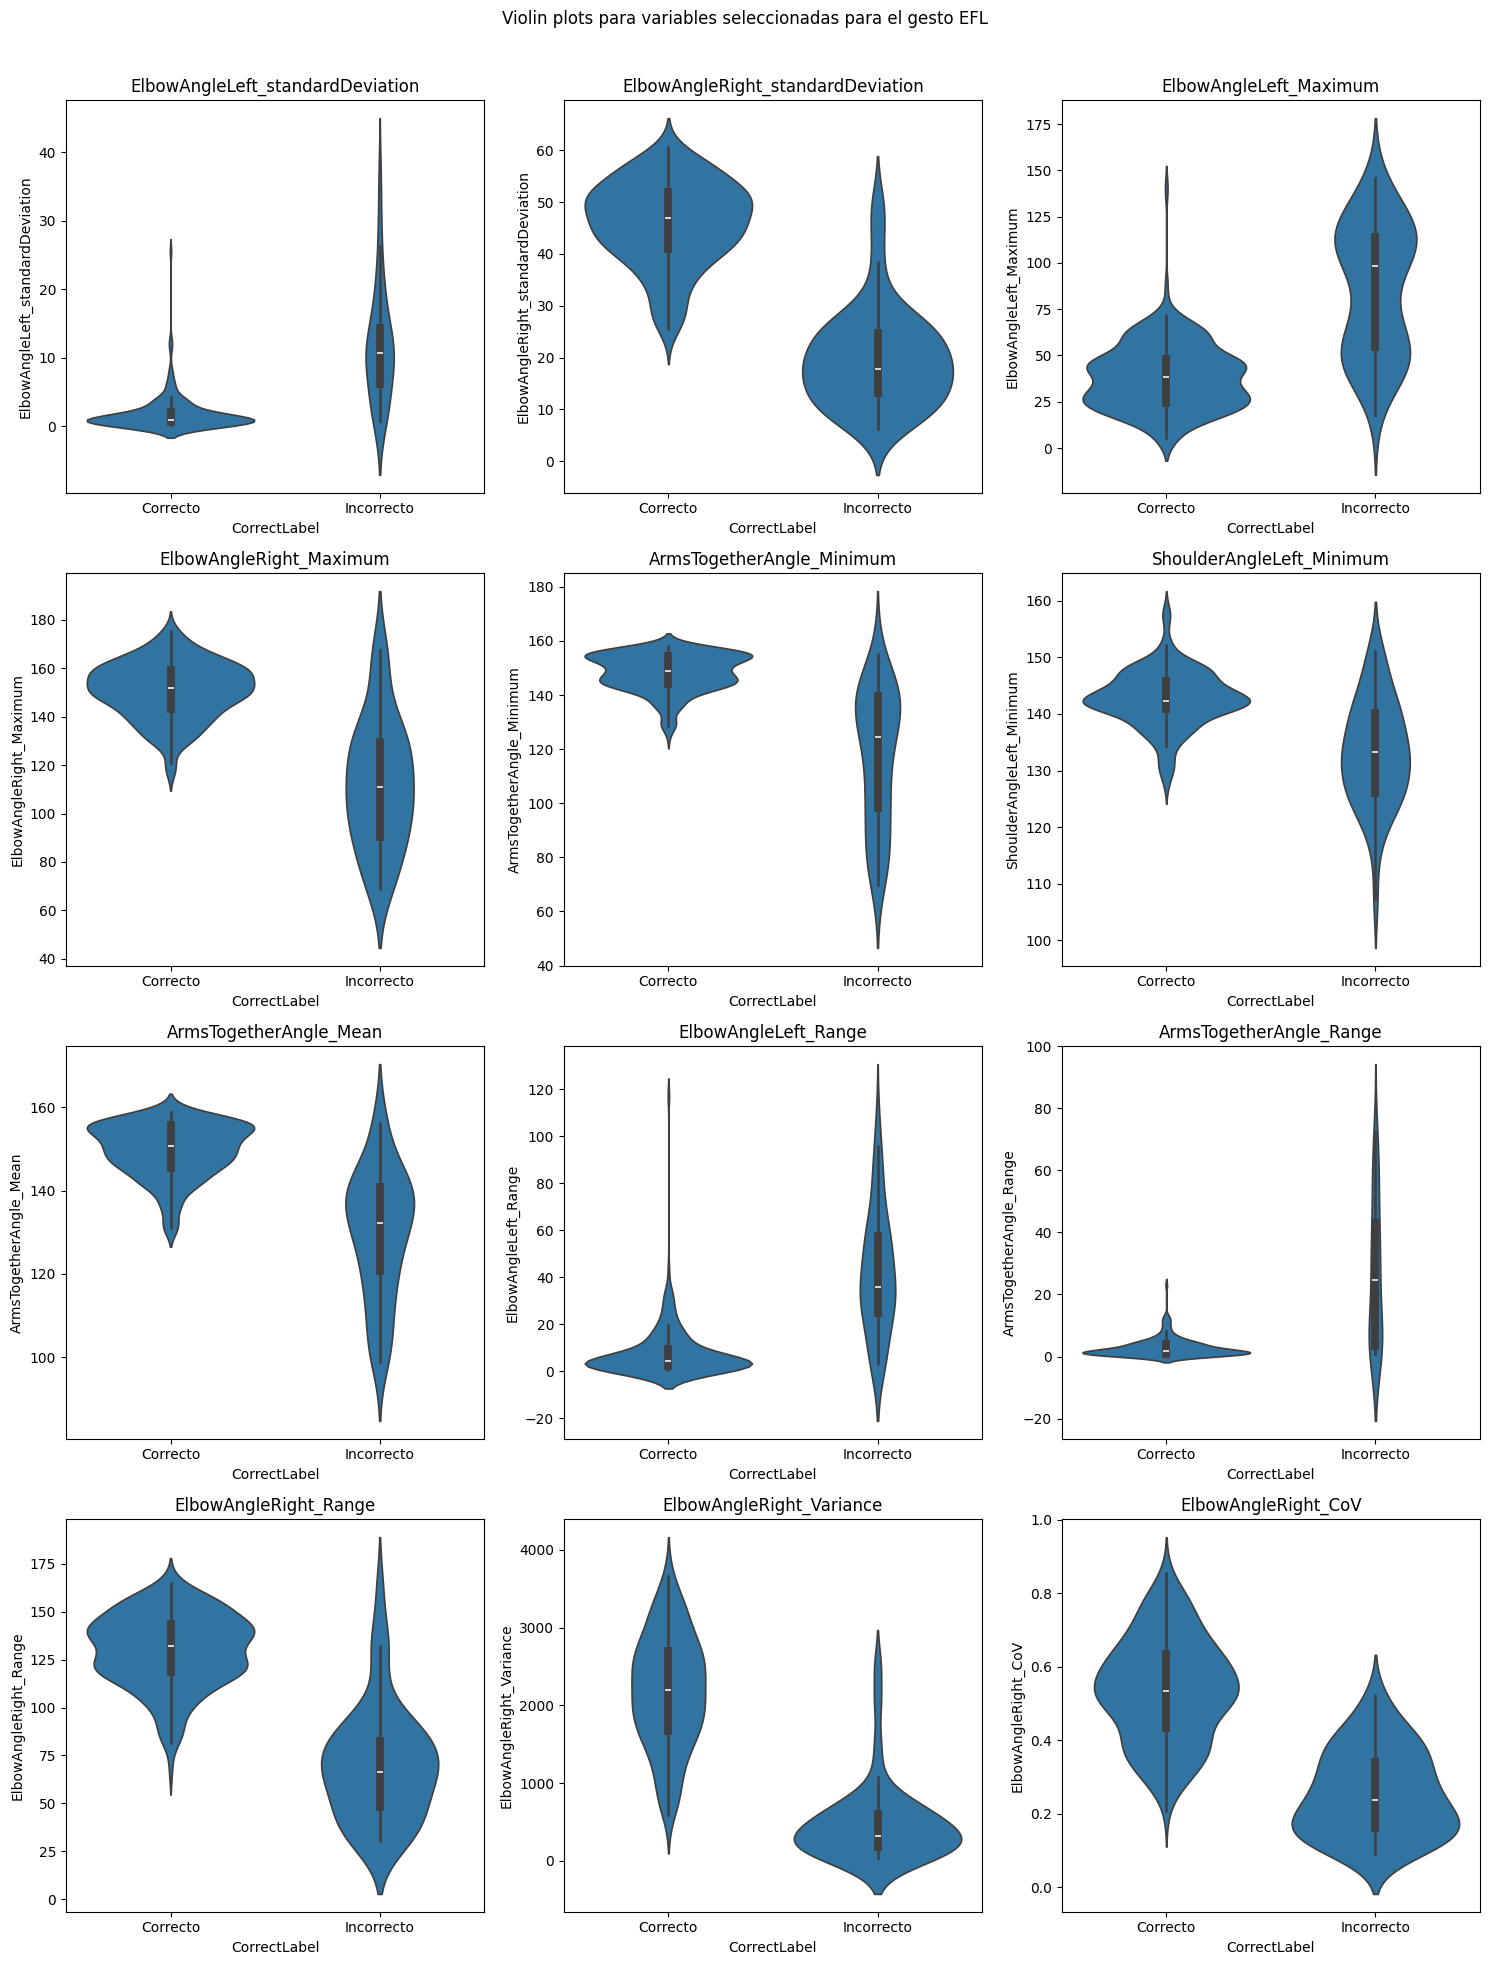

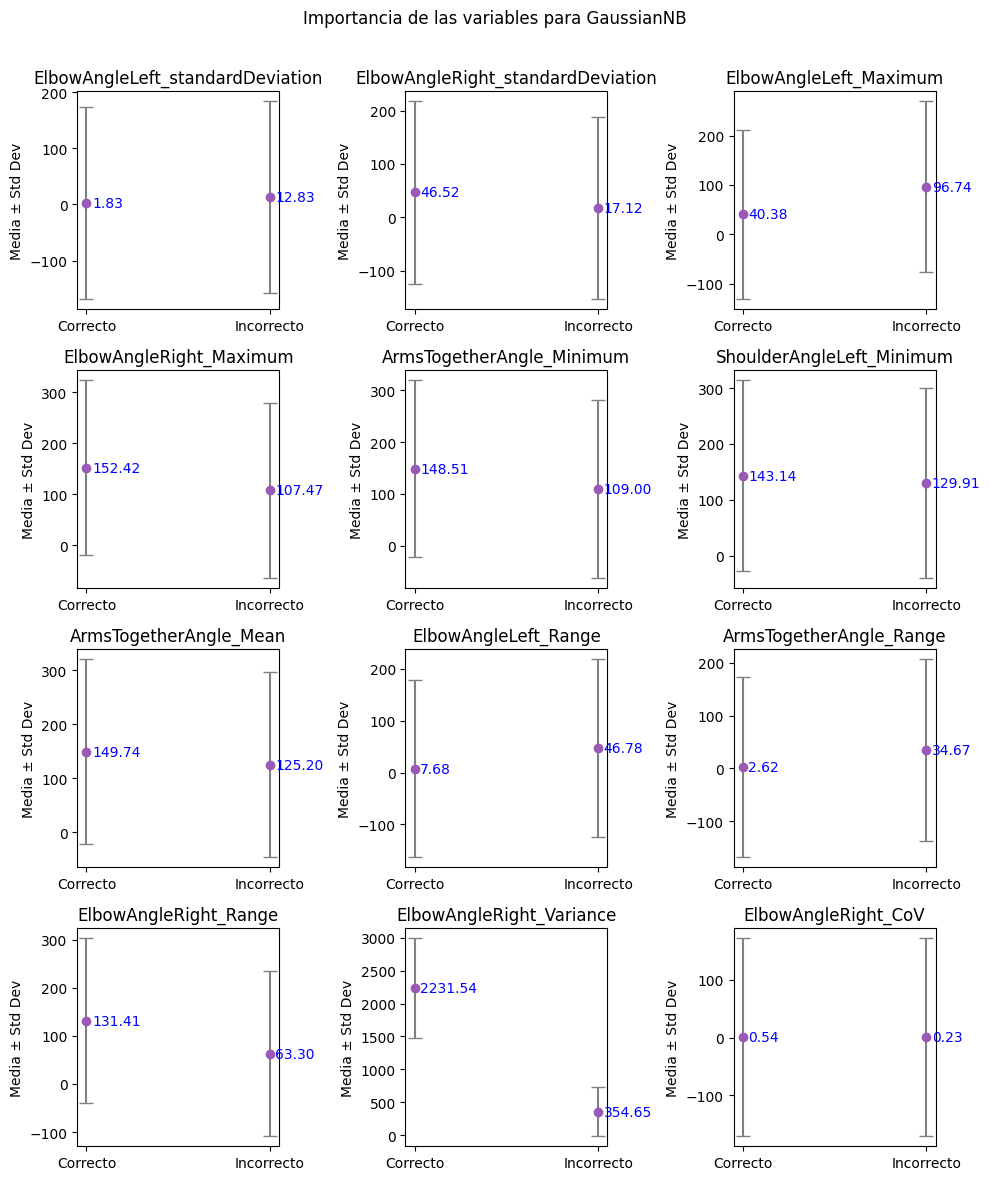

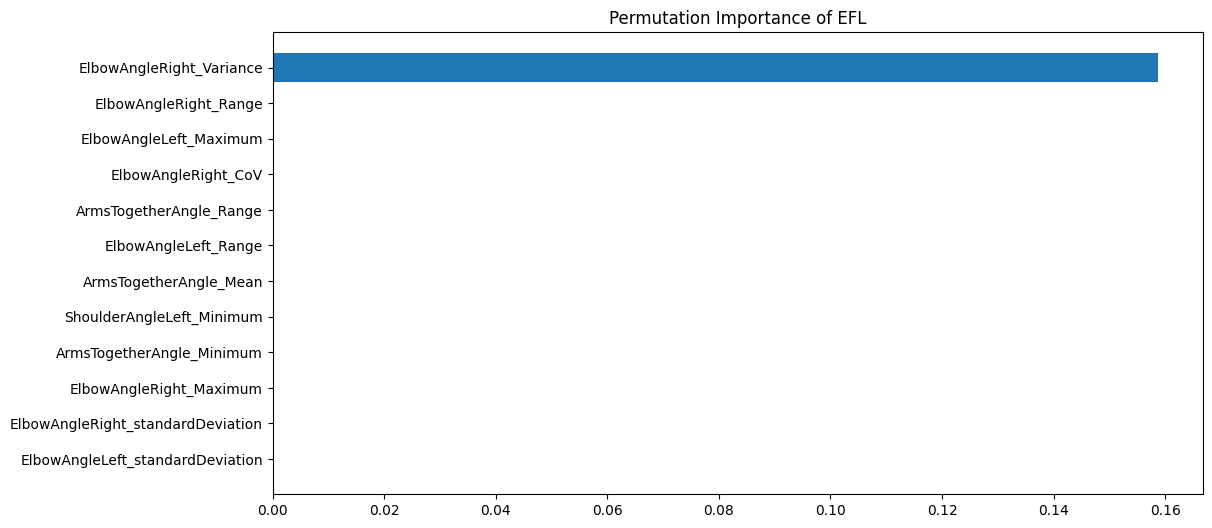

---------------- GESTO EFR 🕺🏻-----------------


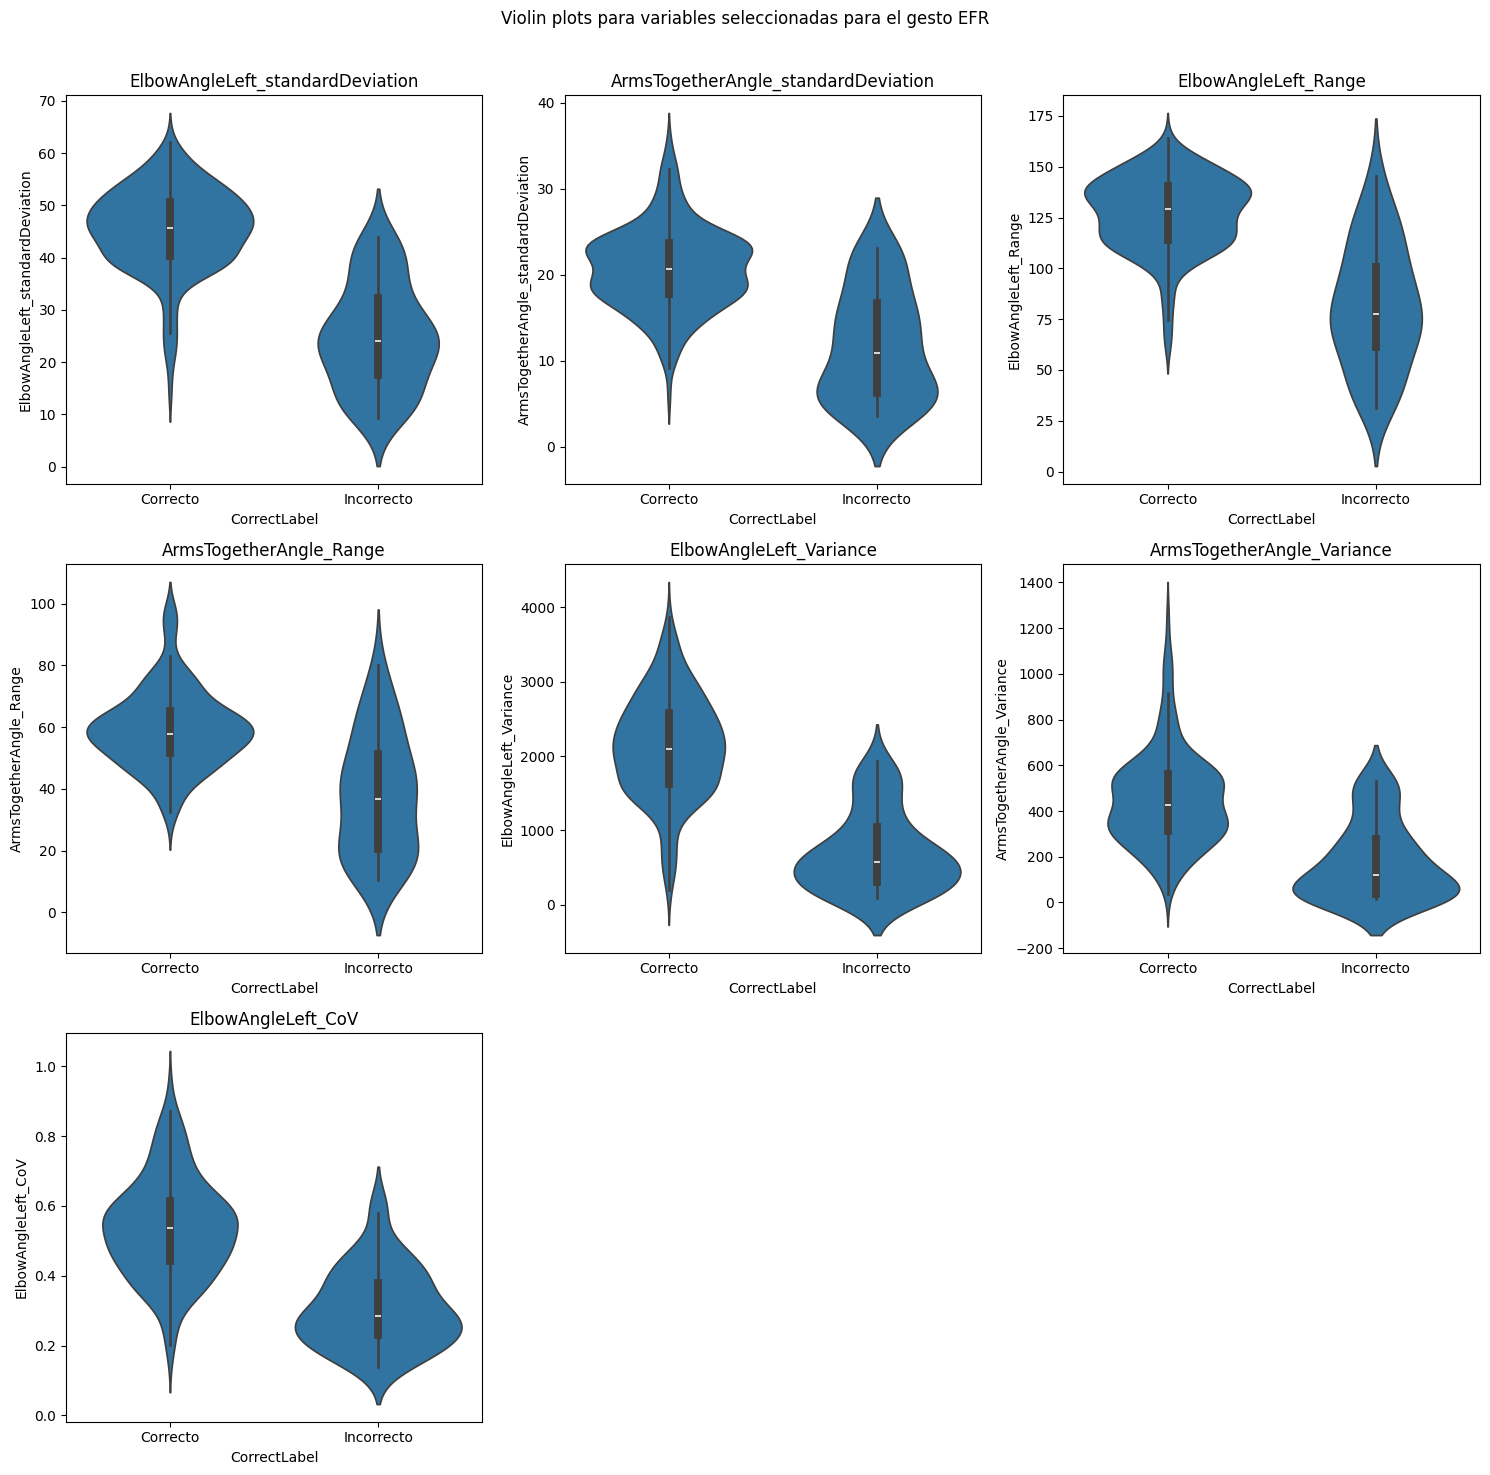

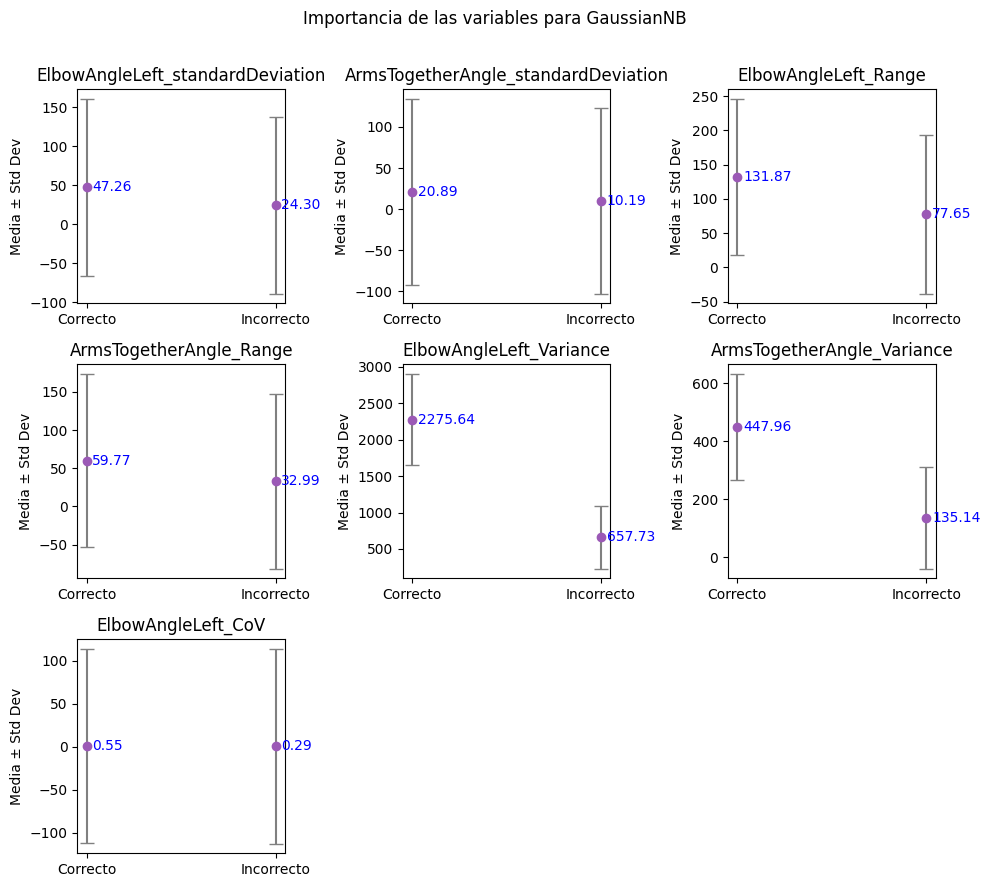

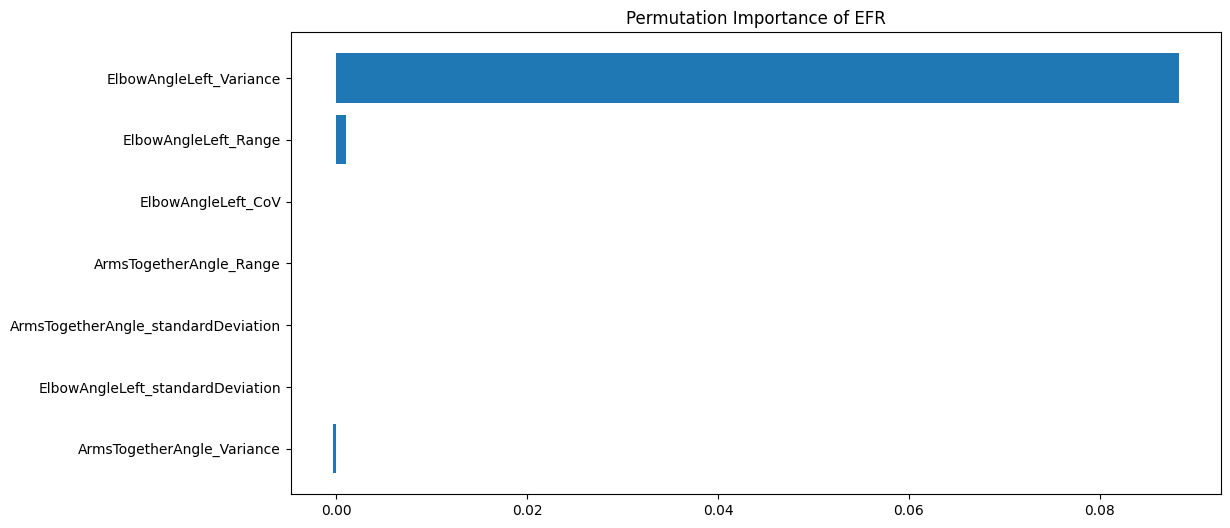

---------------- GESTO SFL 🕺🏻-----------------


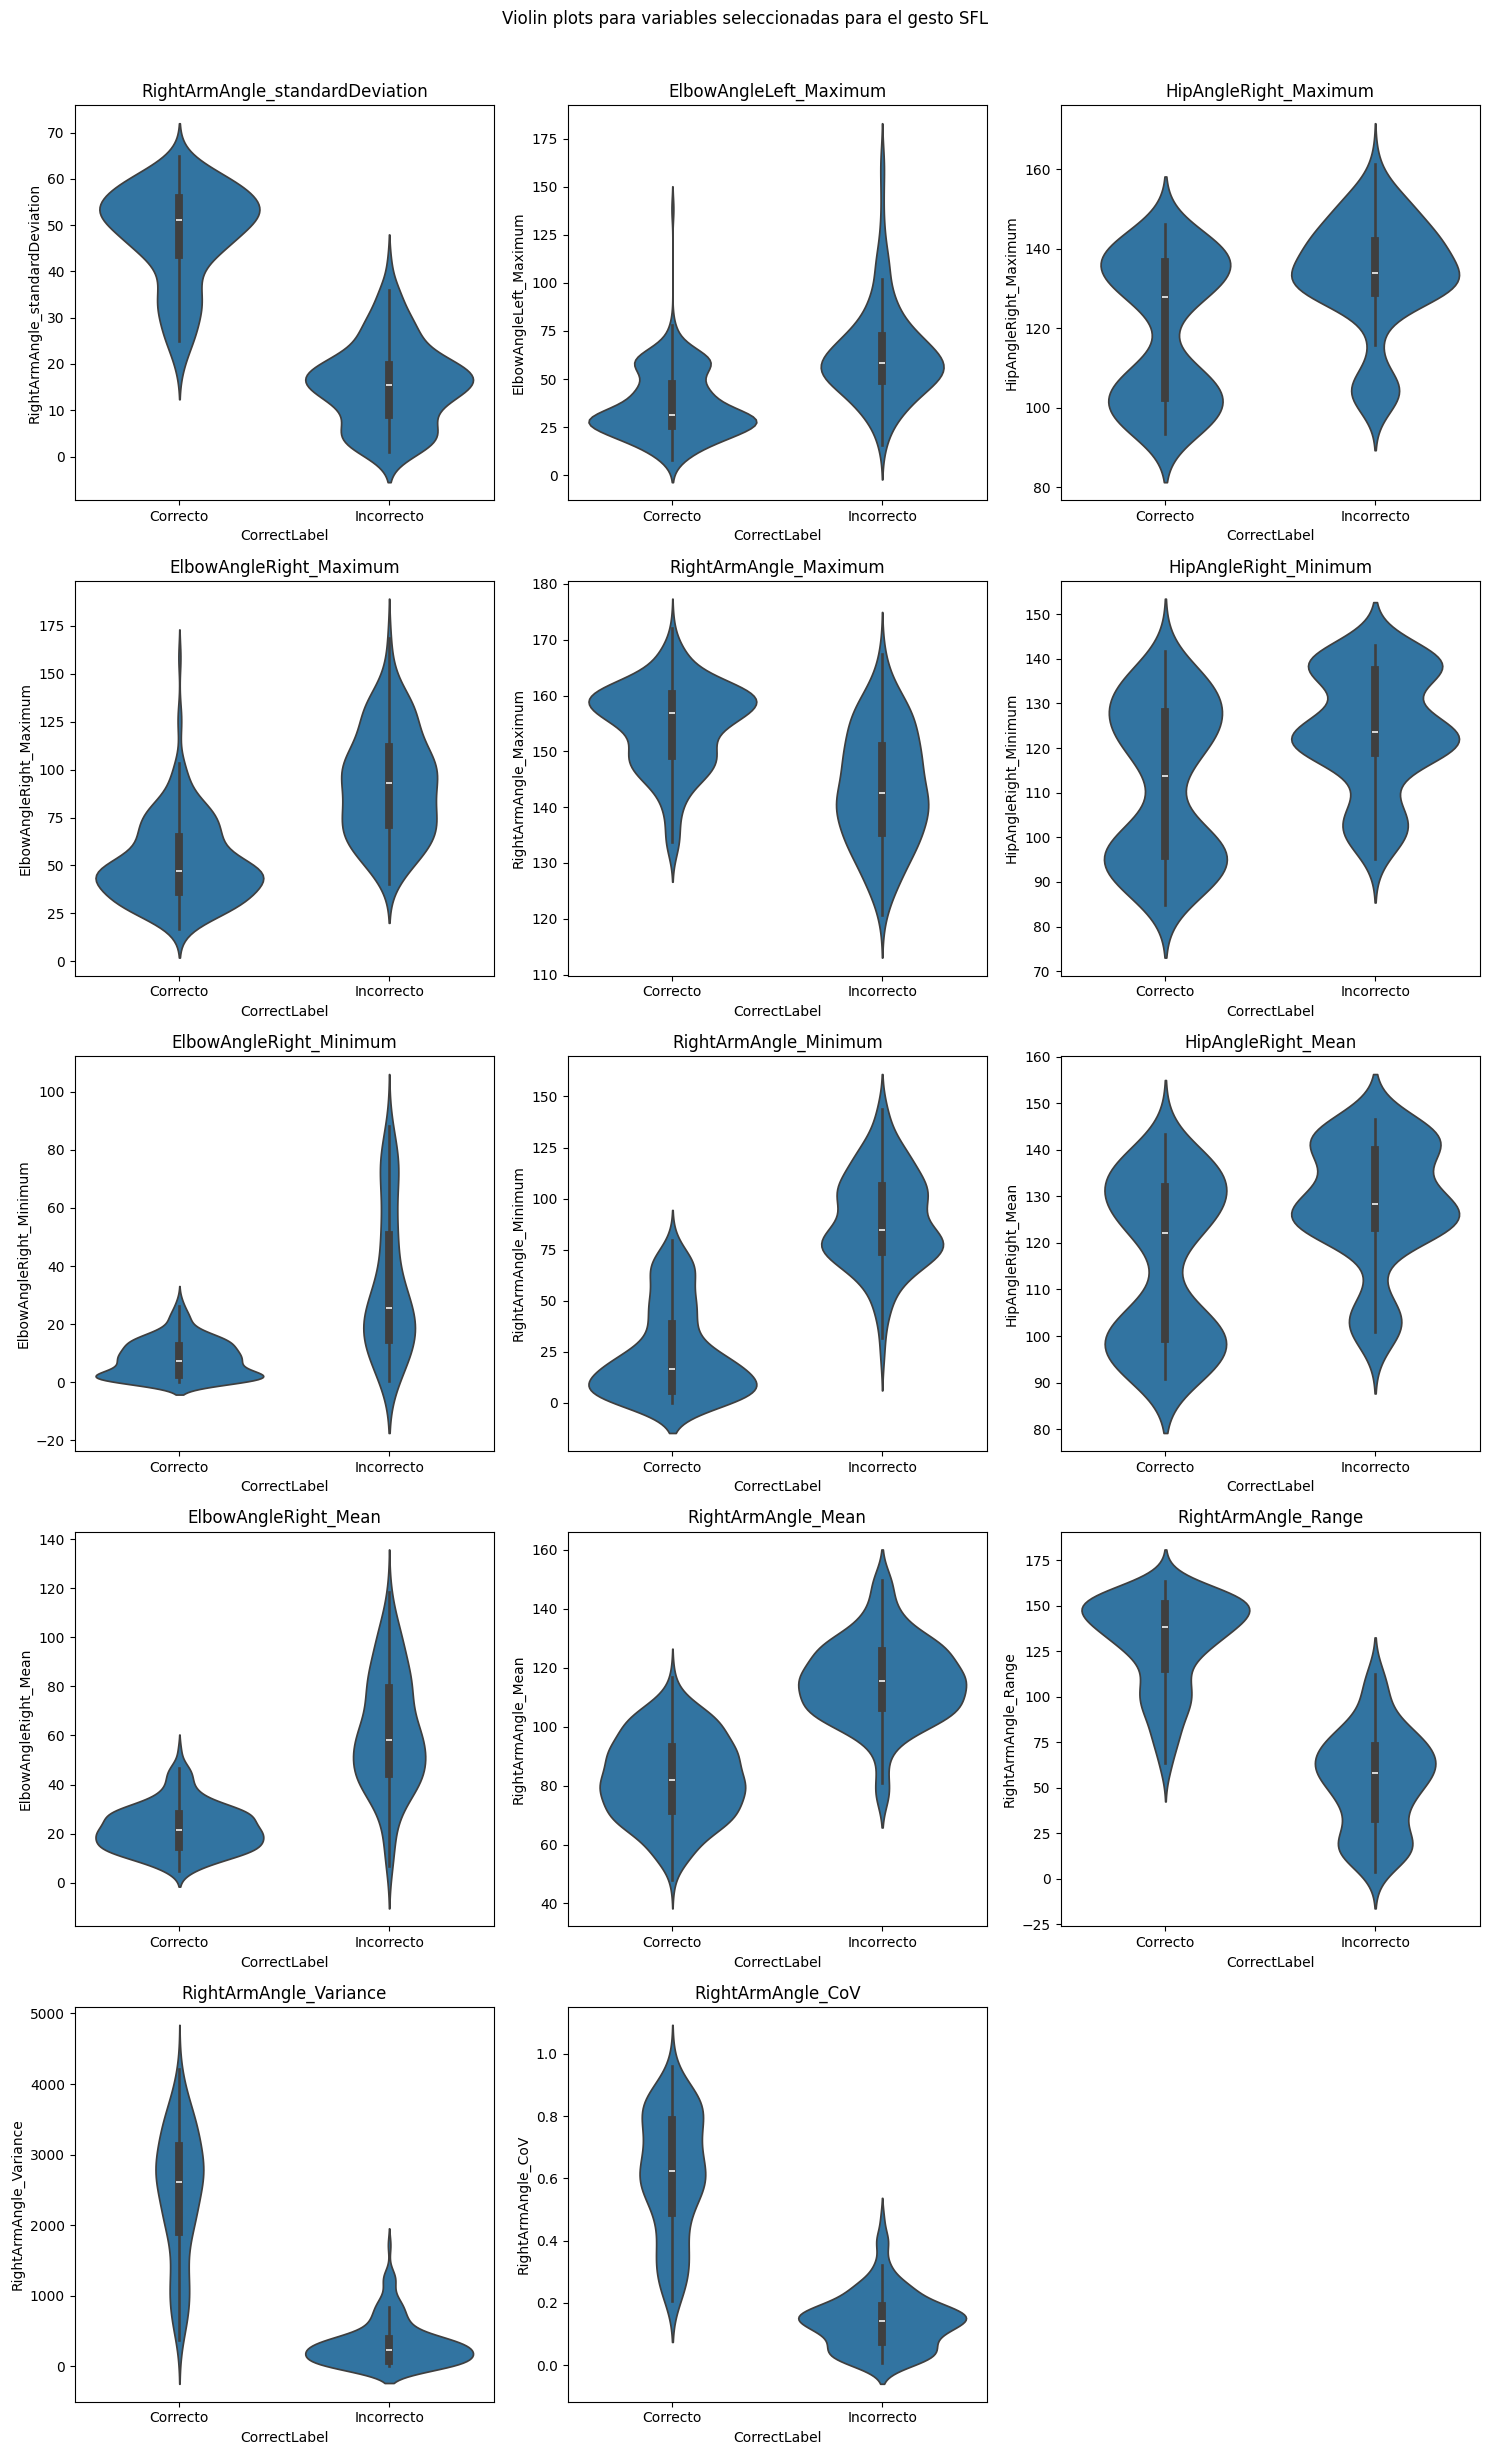

<Figure size 640x480 with 0 Axes>

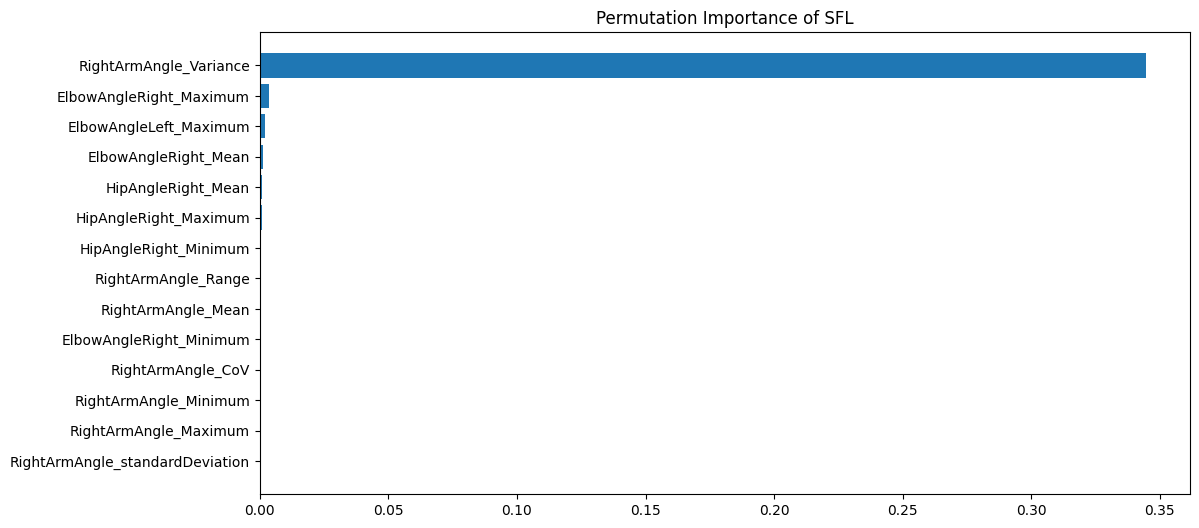

---------------- GESTO SFR 🕺🏻-----------------


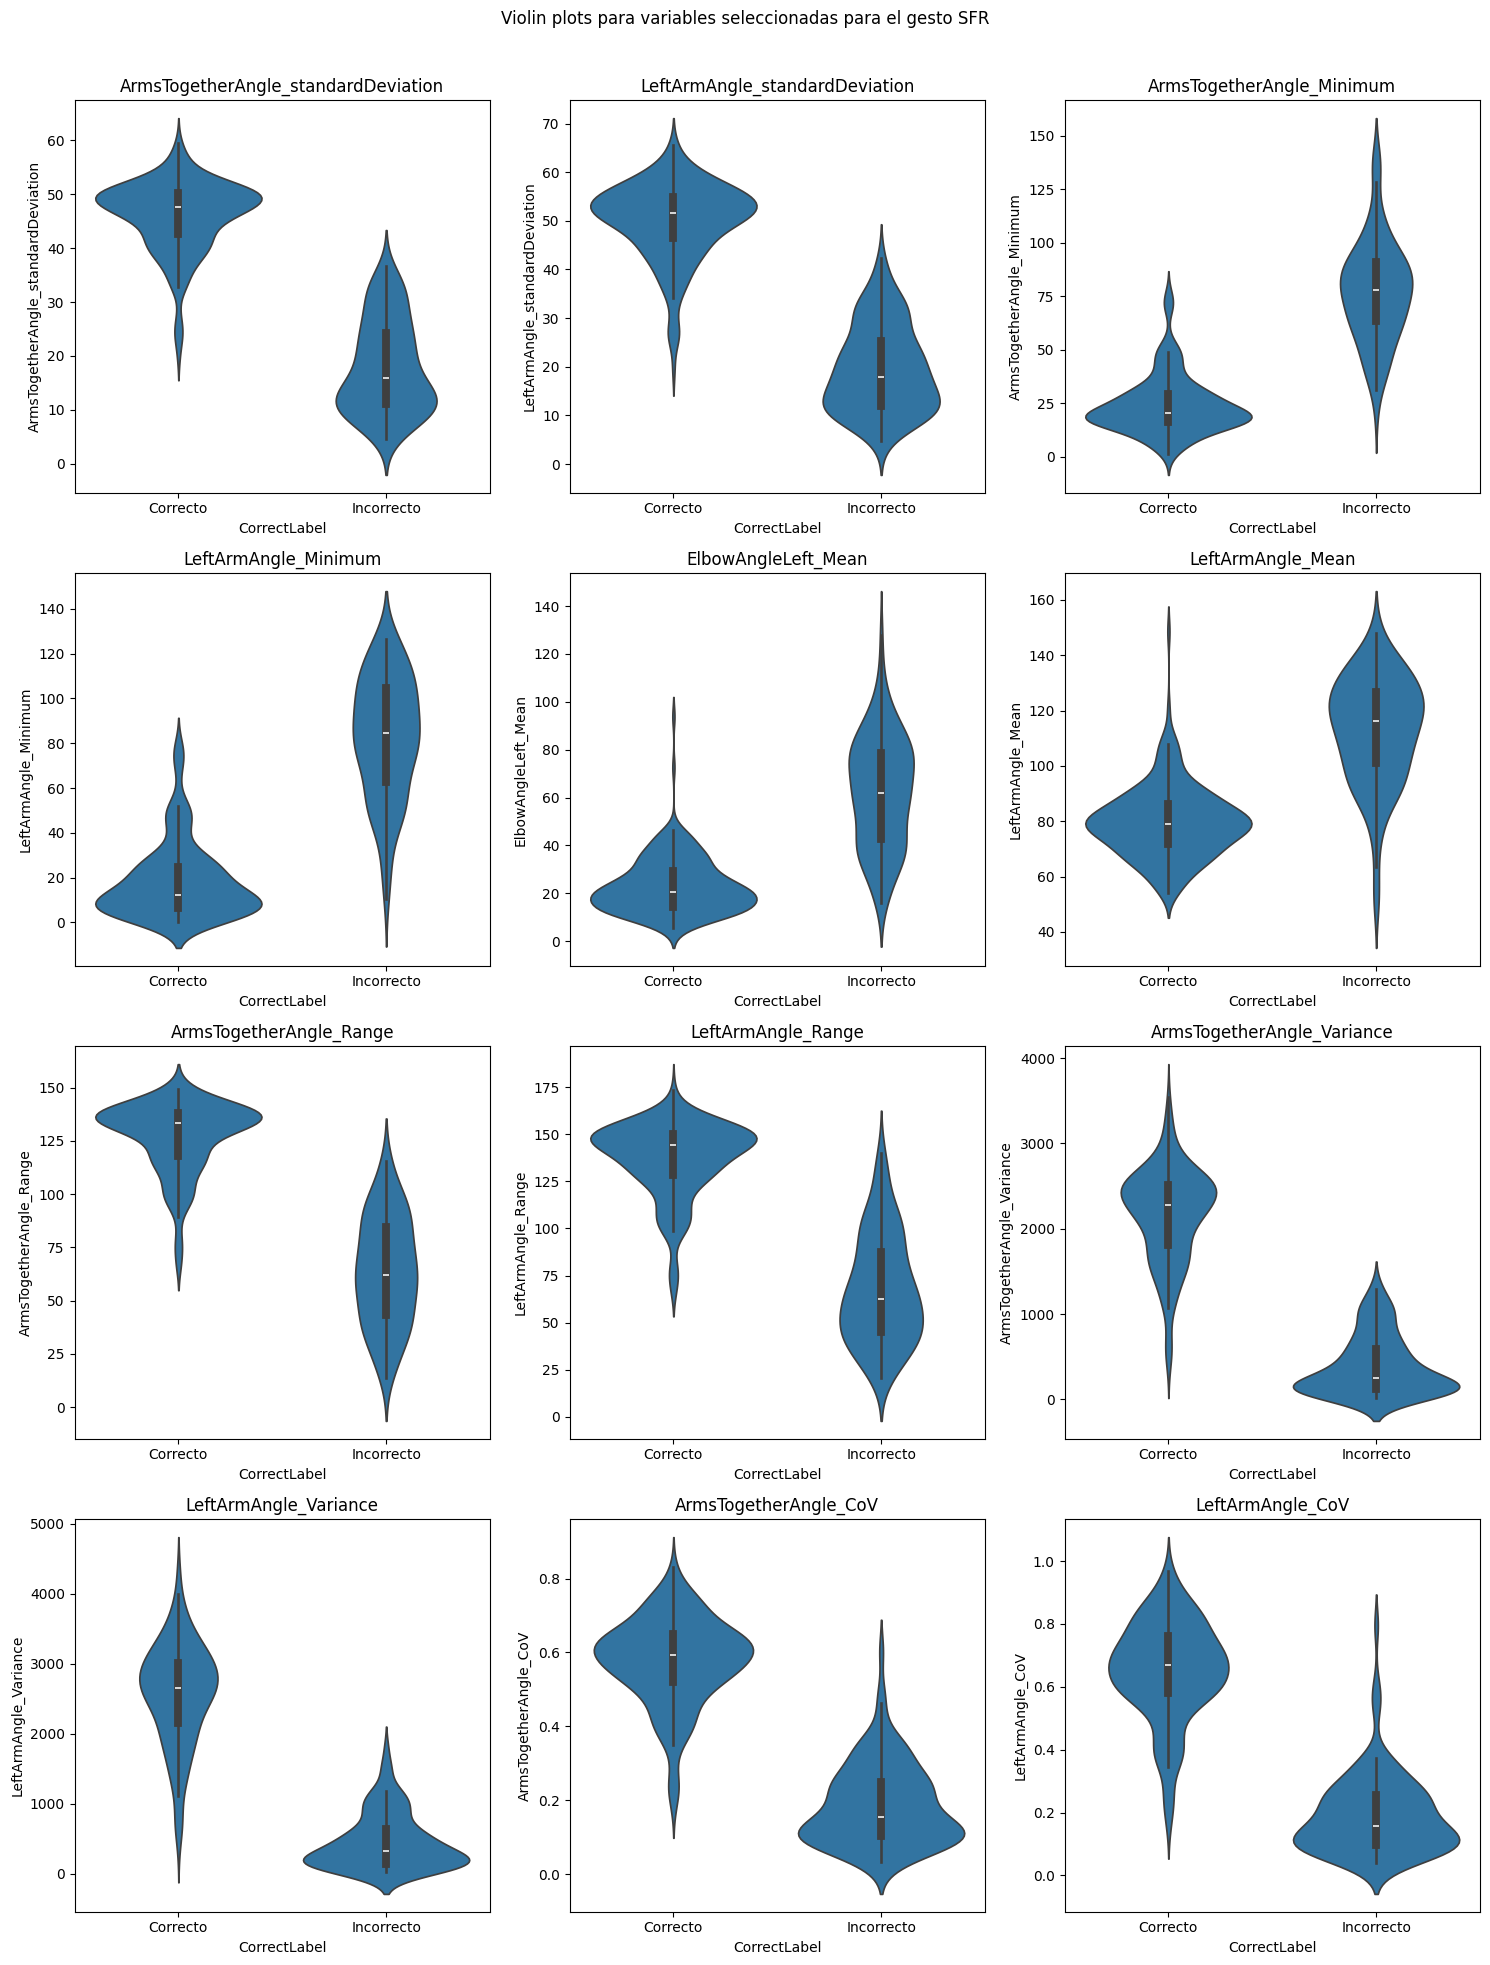

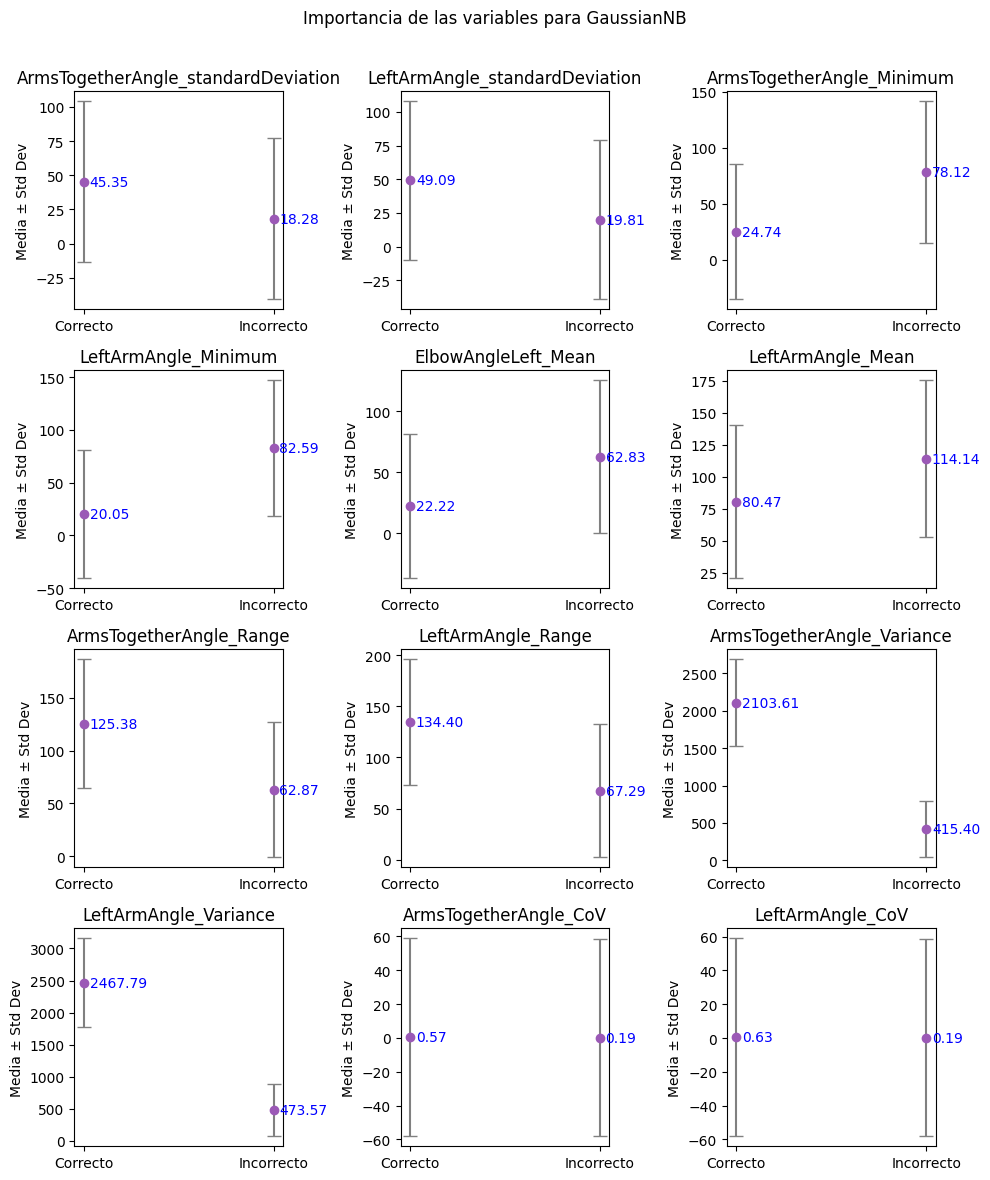

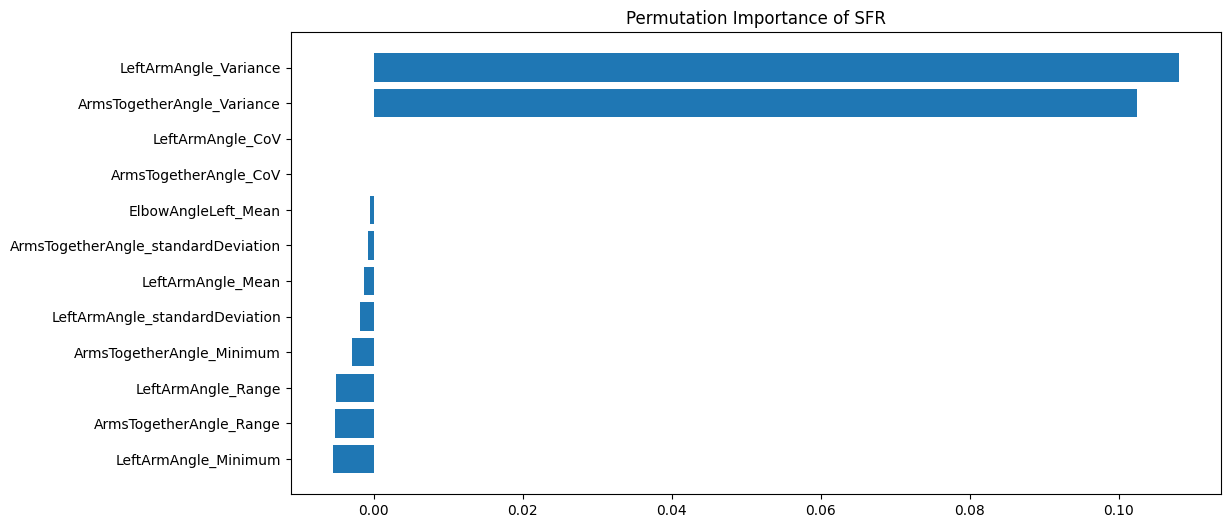

---------------- GESTO SAL 🕺🏻-----------------


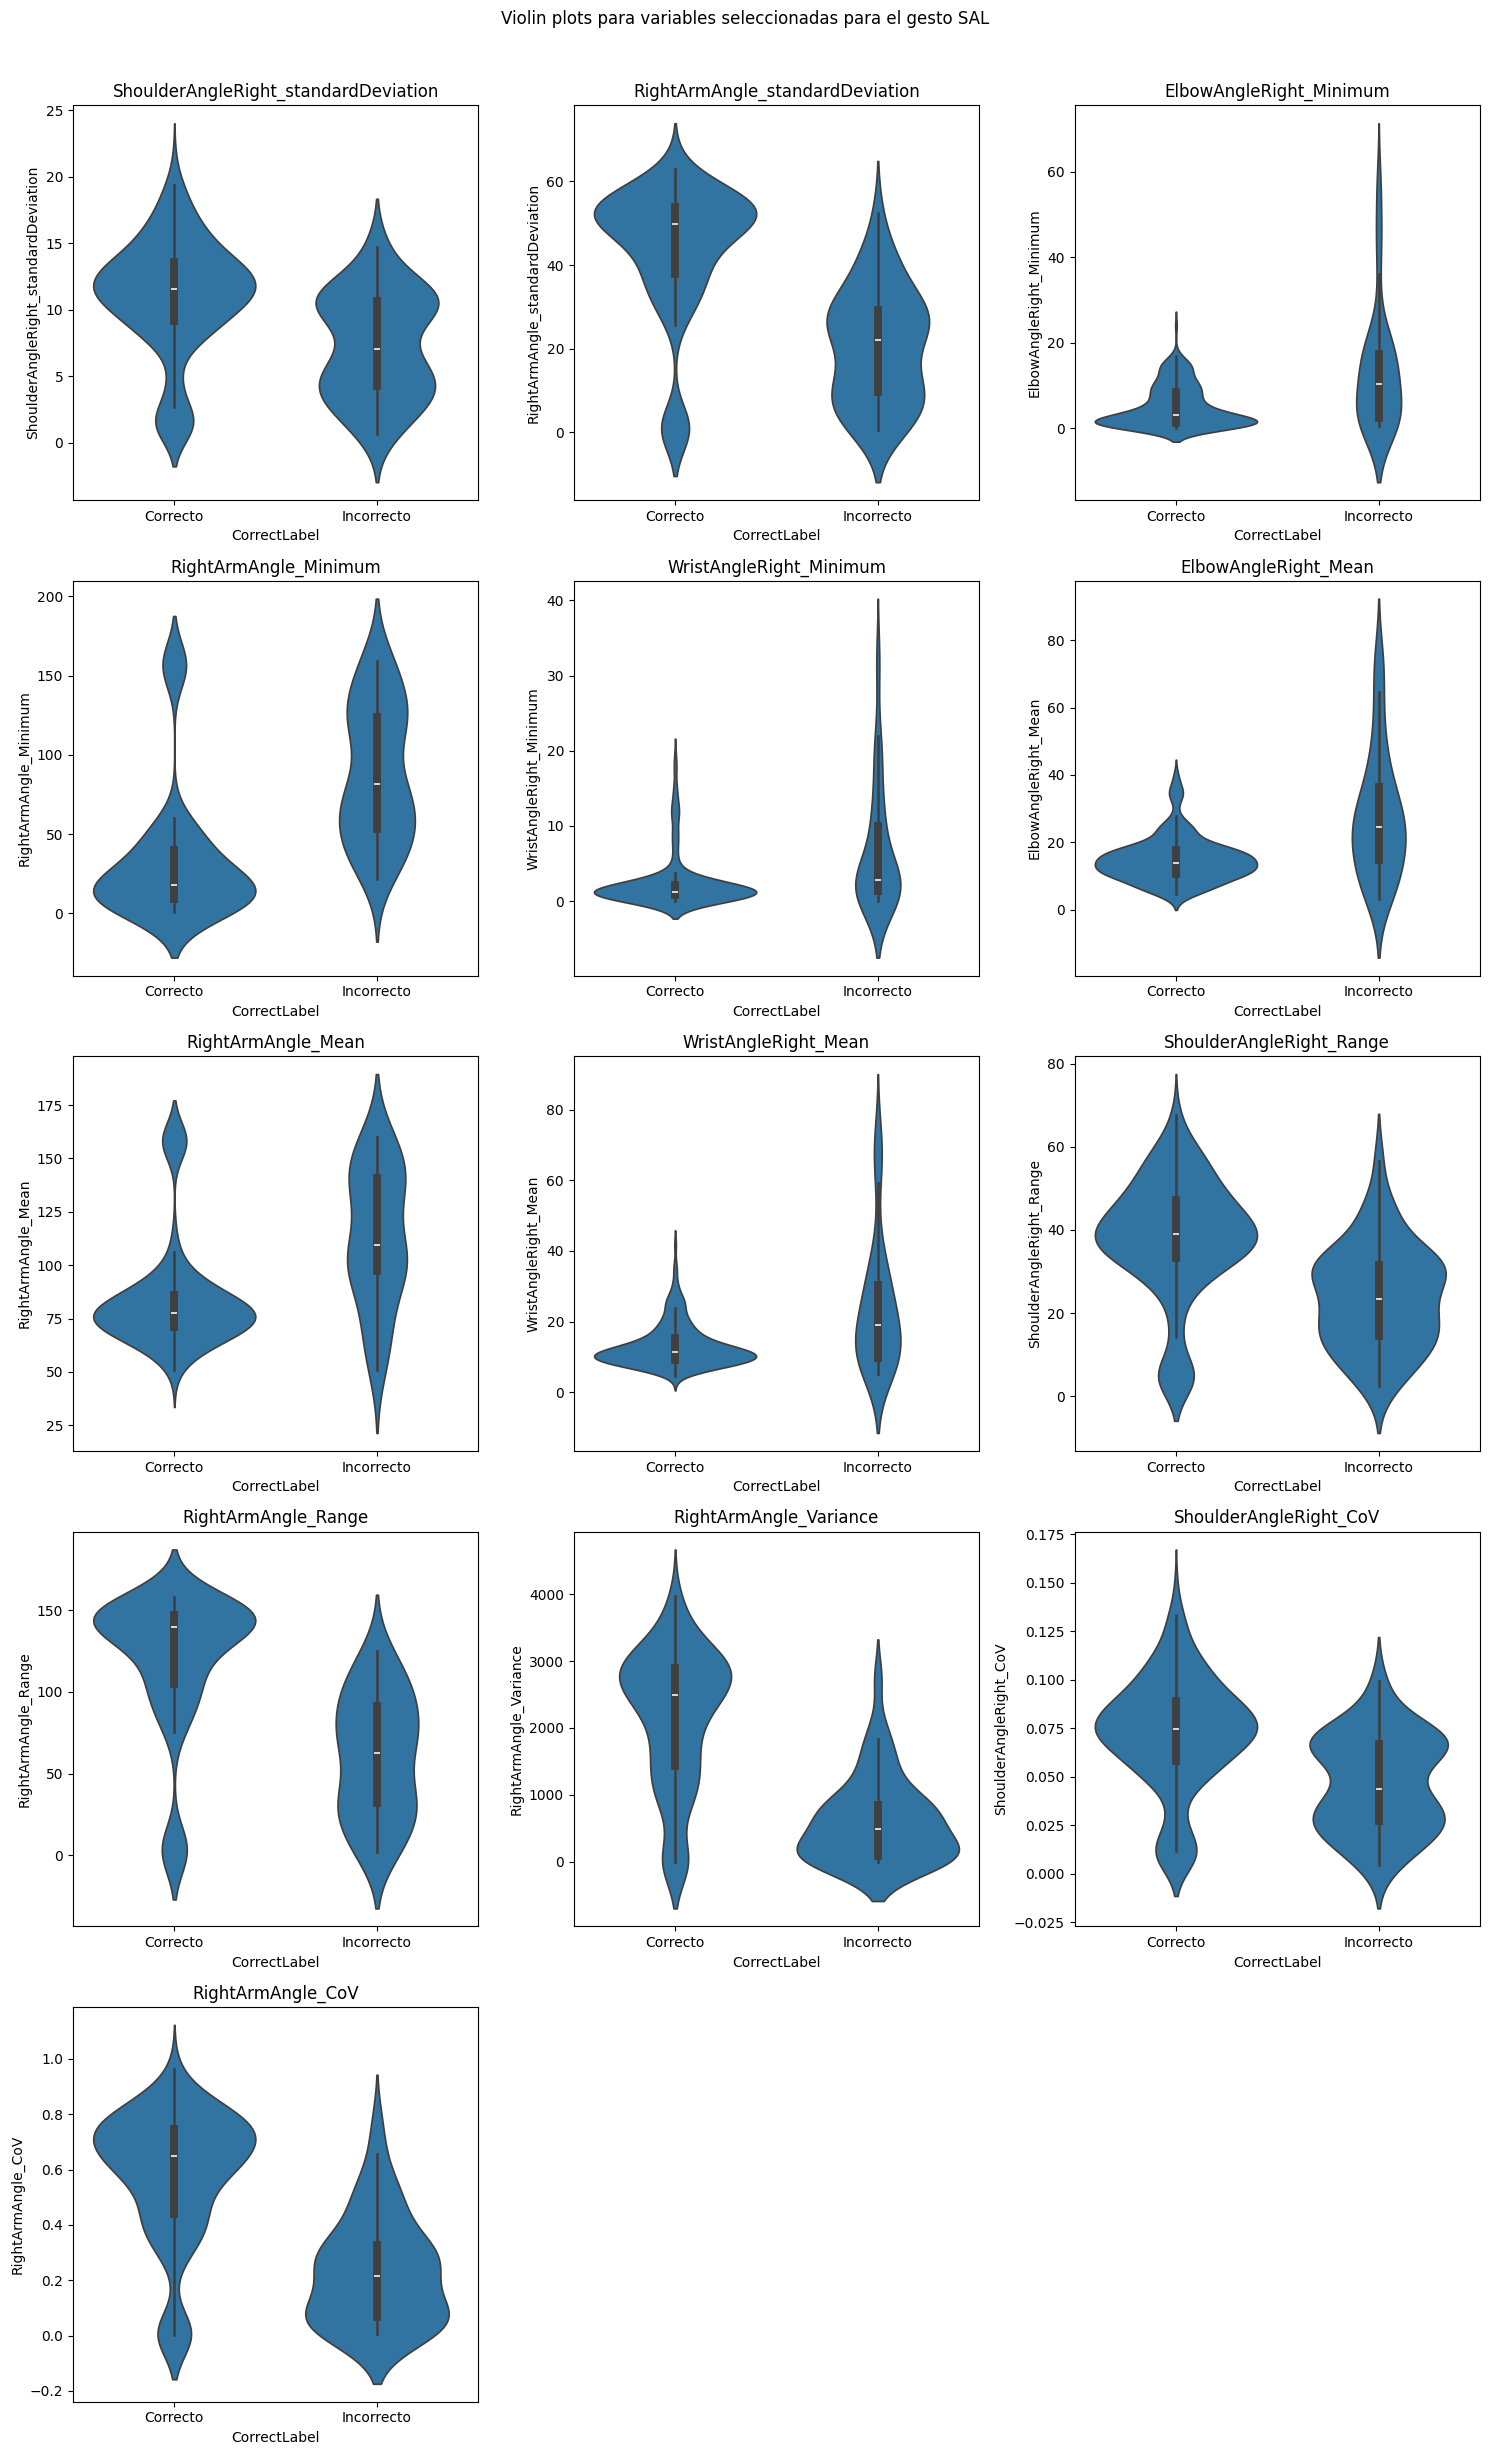

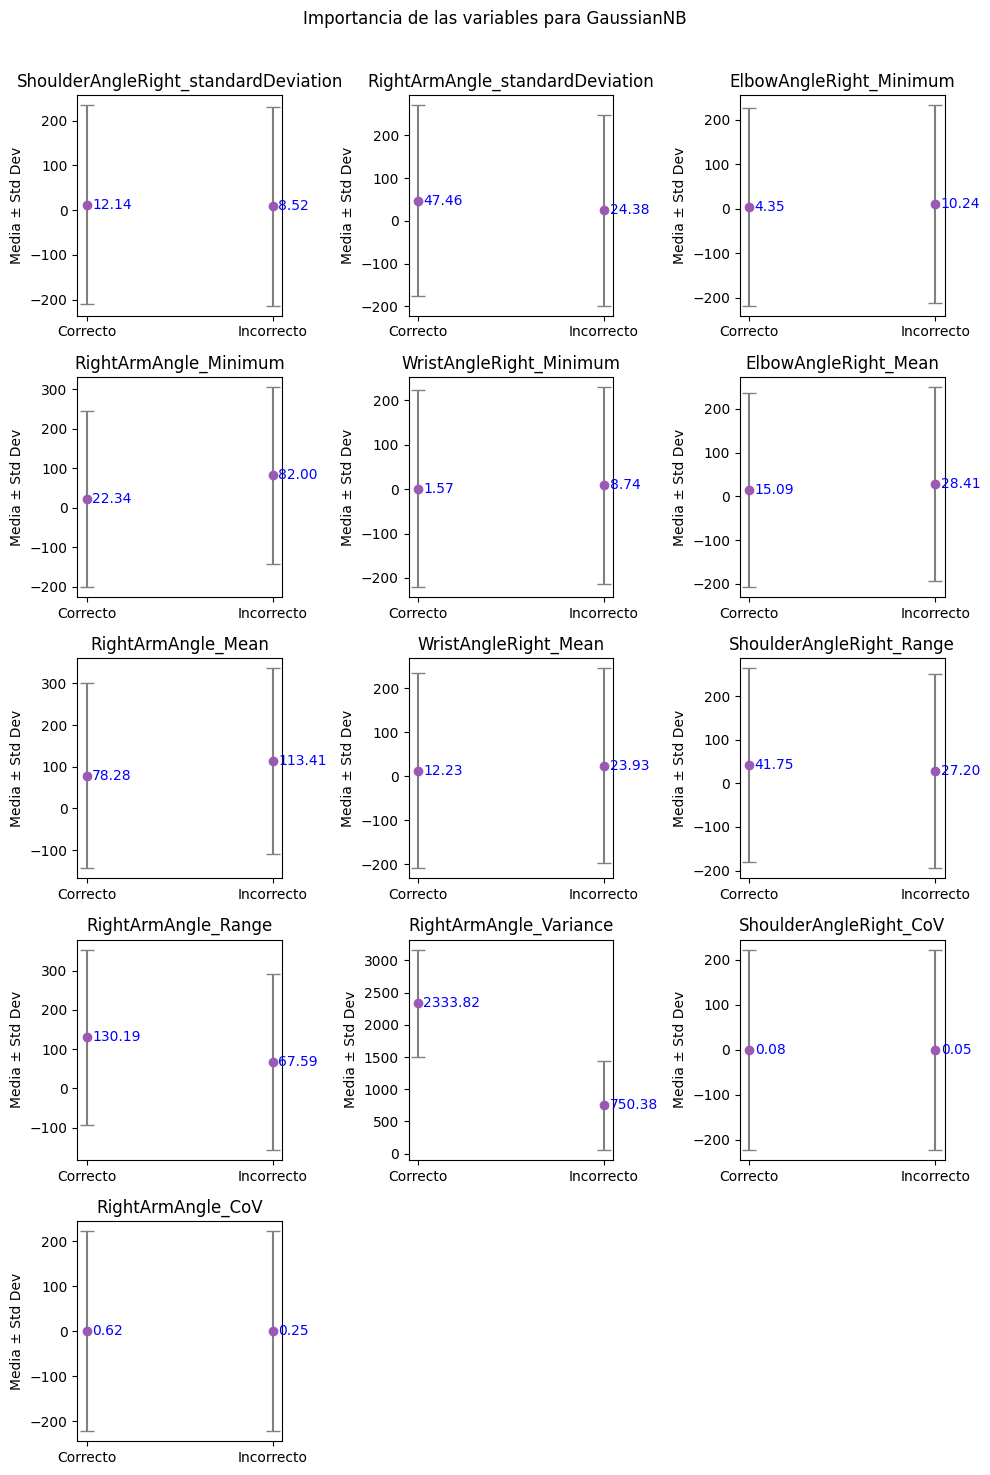

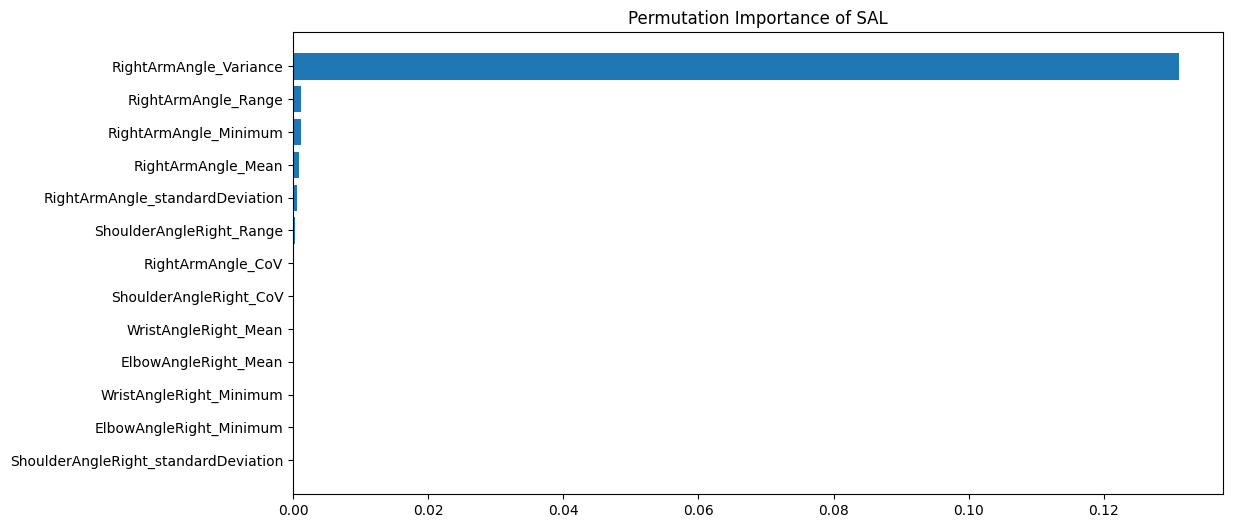

---------------- GESTO SAR 🕺🏻-----------------


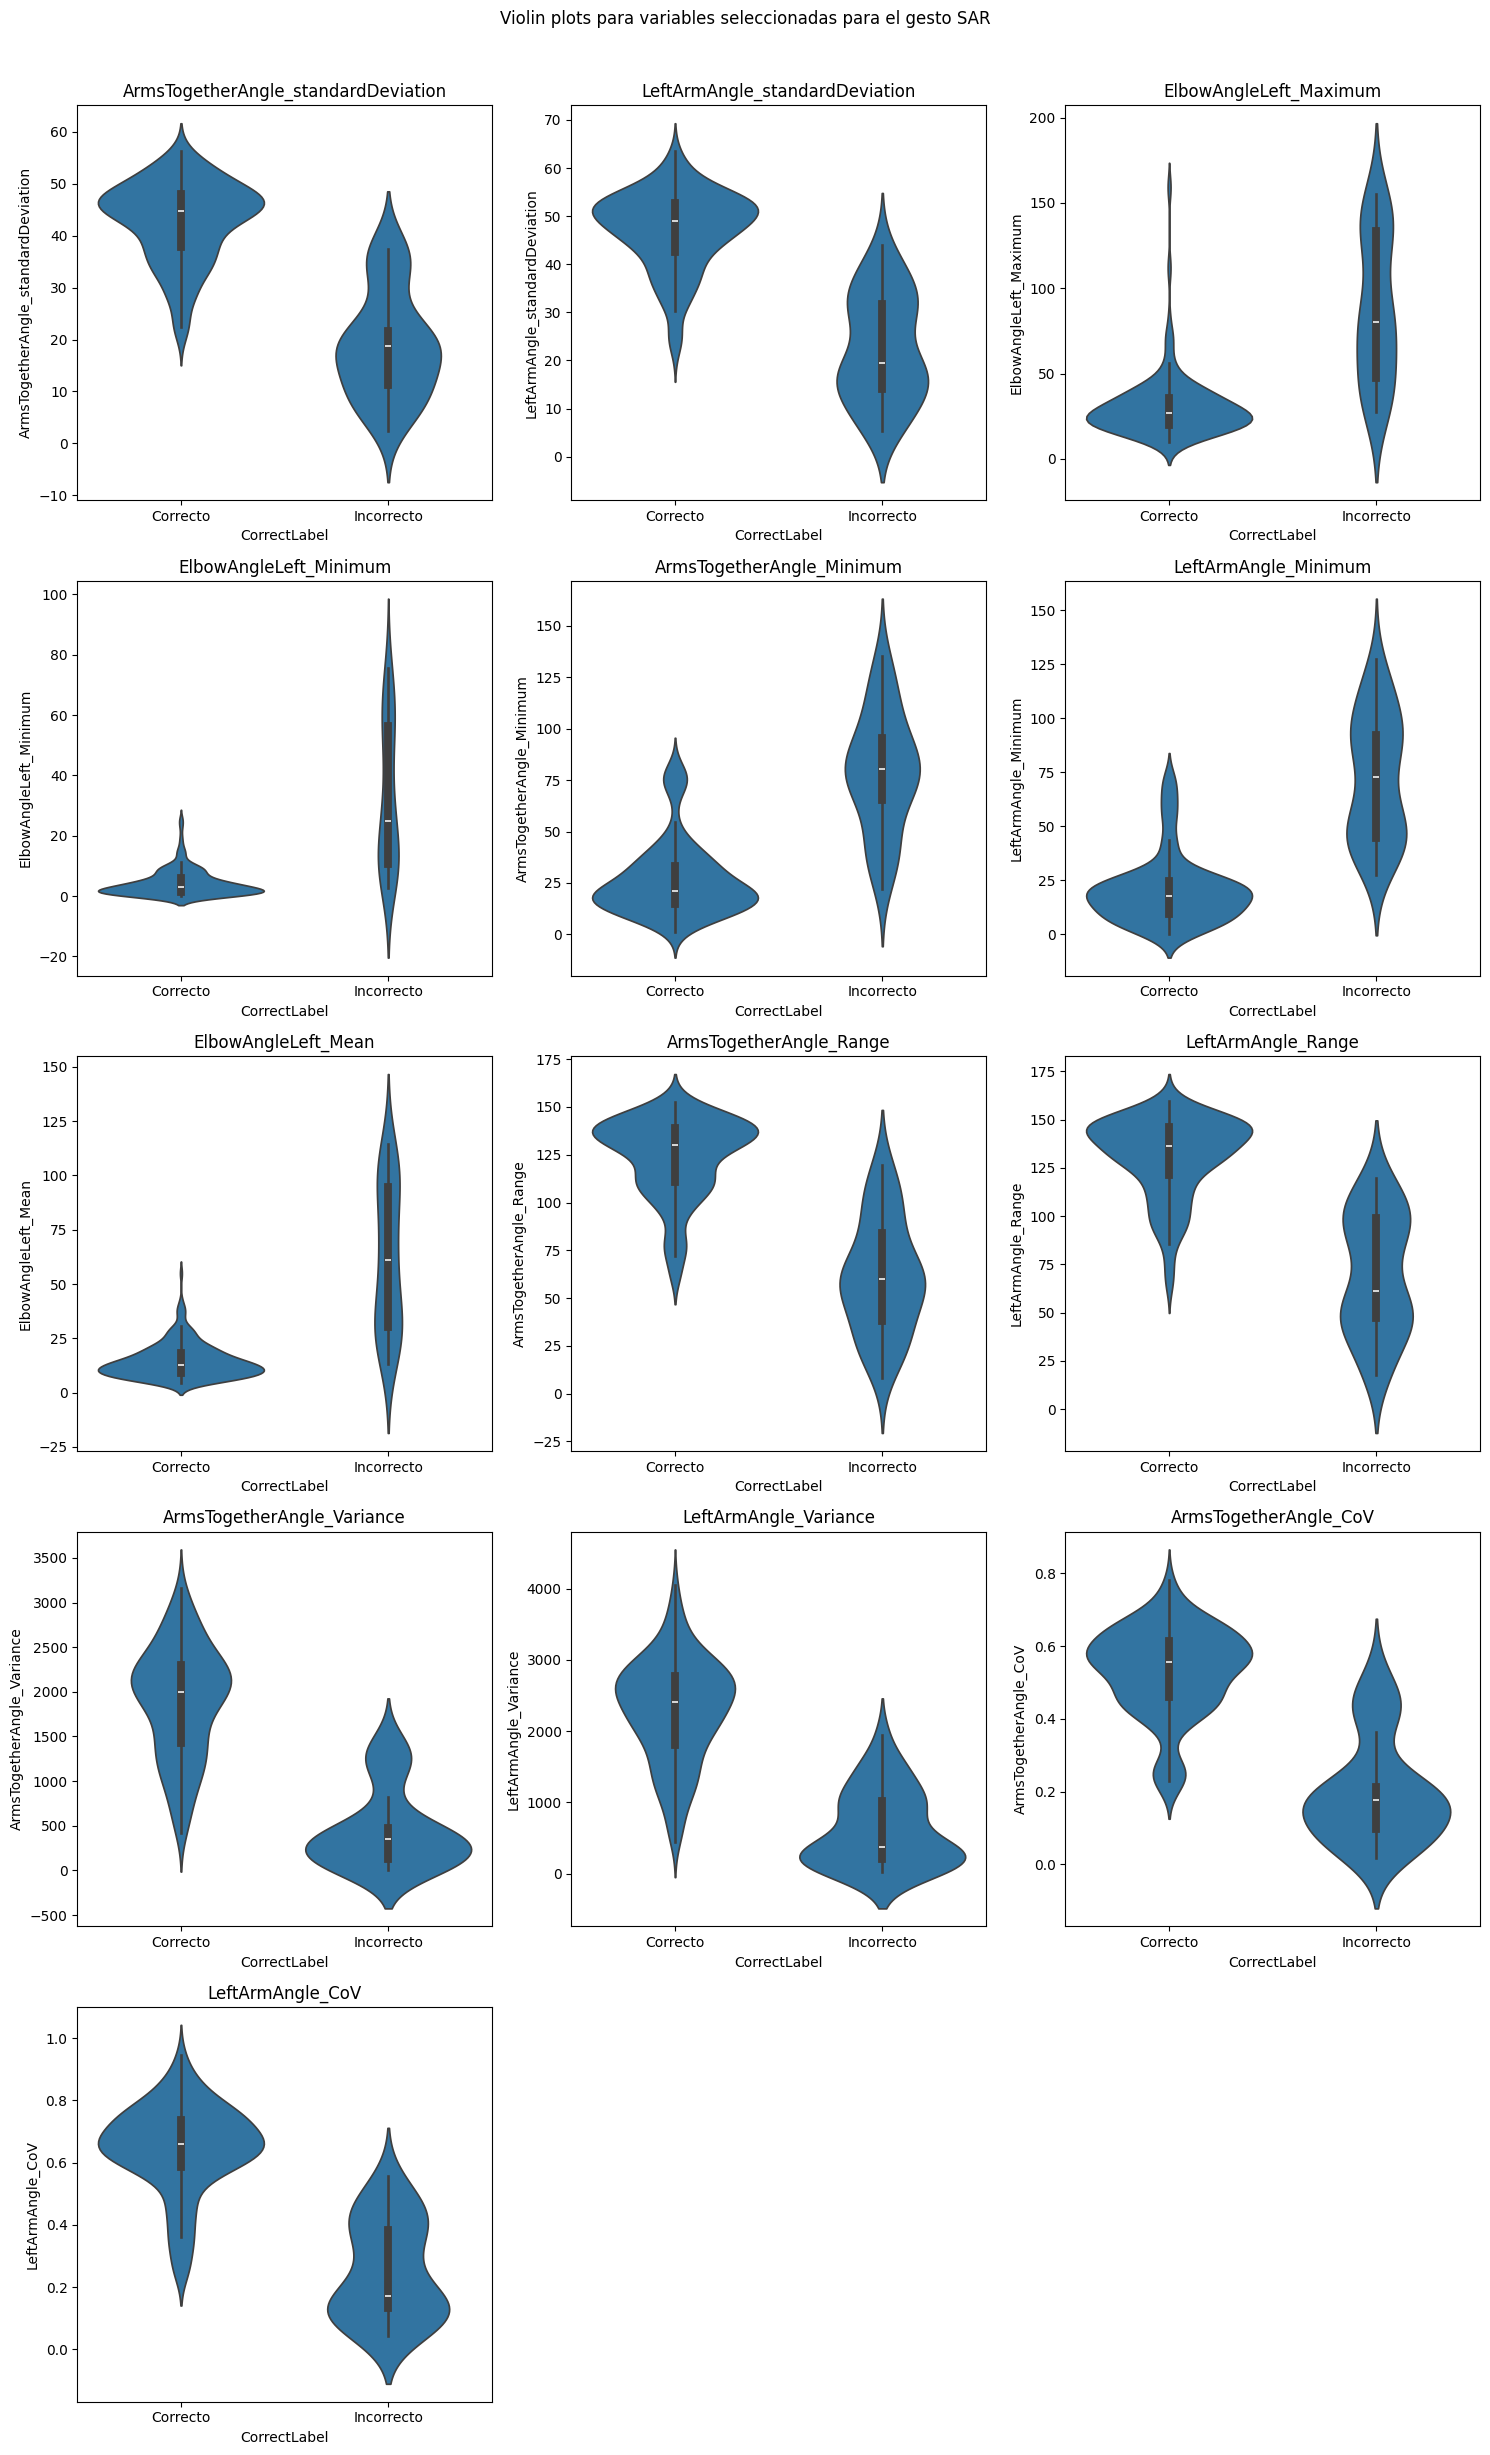

<Figure size 640x480 with 0 Axes>

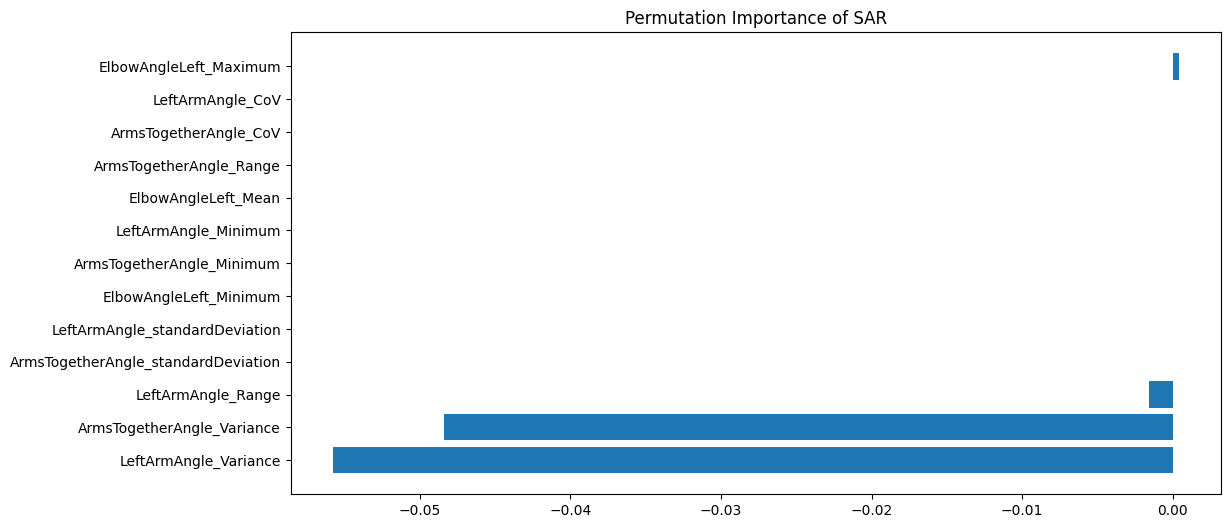

---------------- GESTO SFE 🕺🏻-----------------


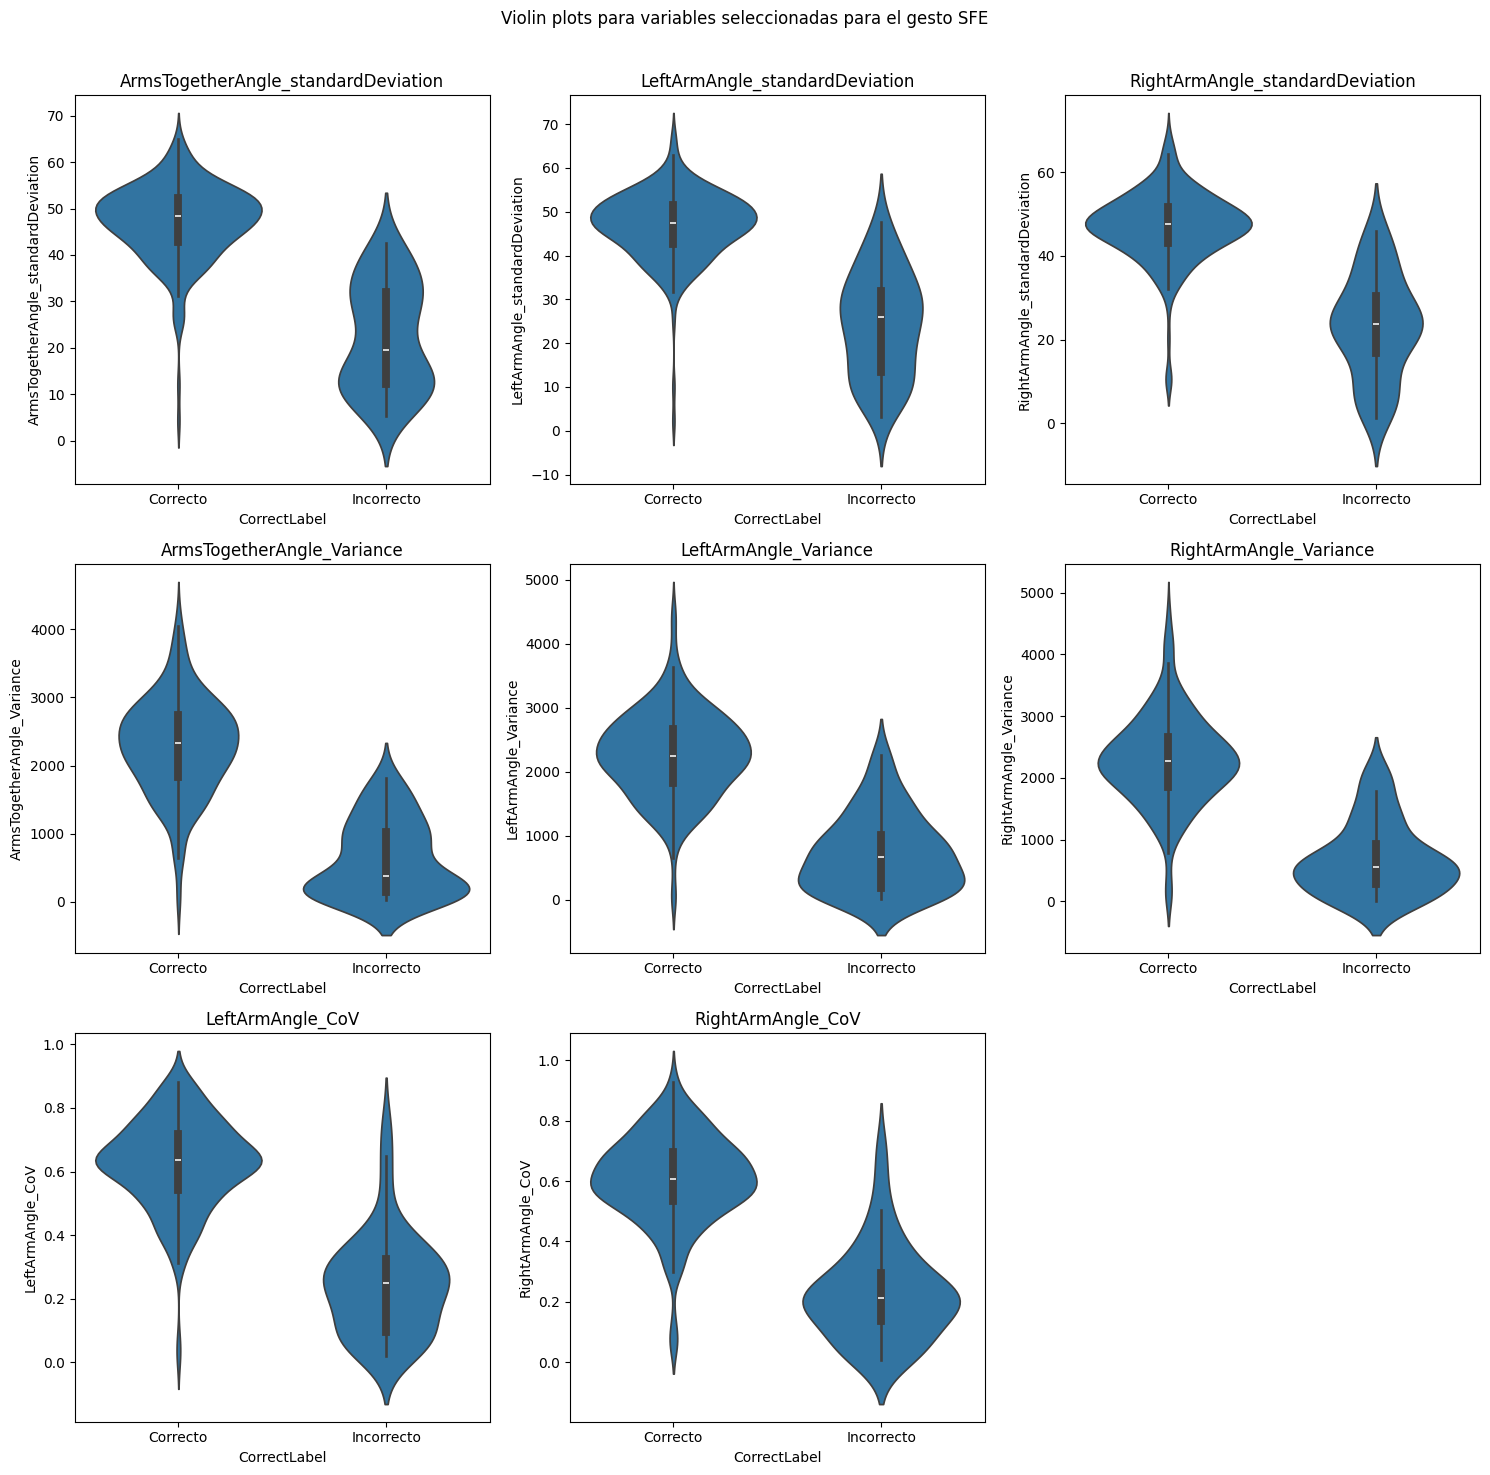

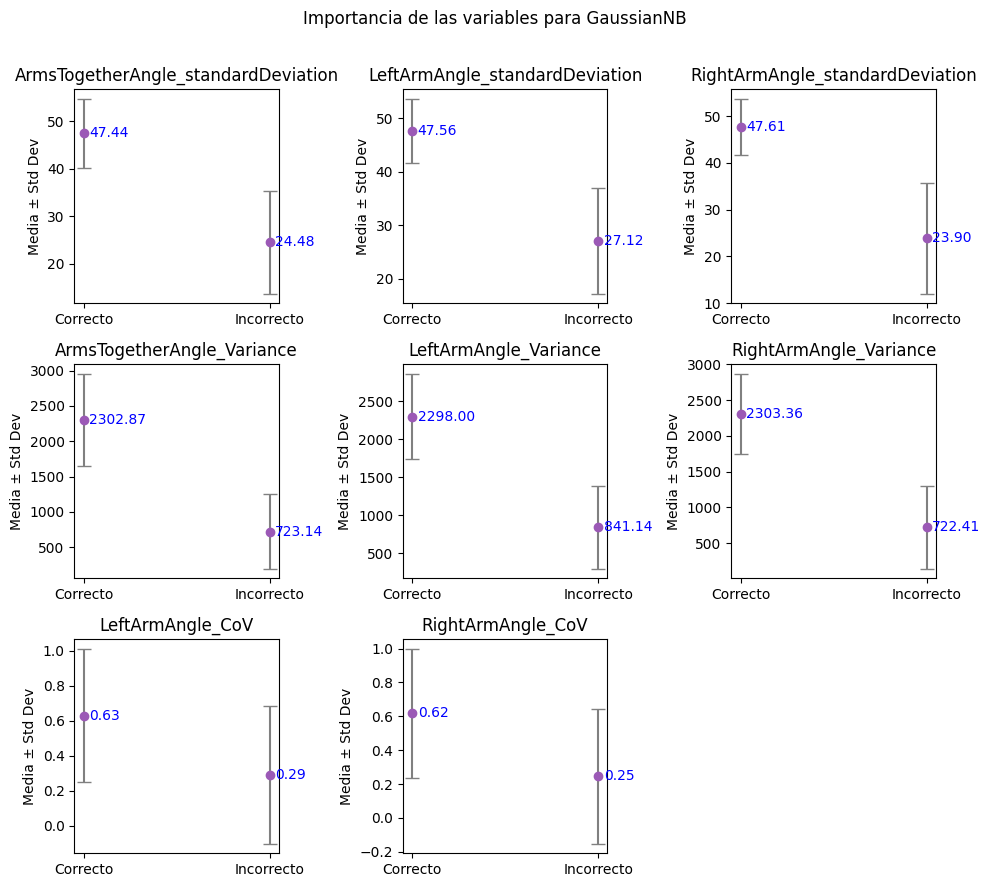

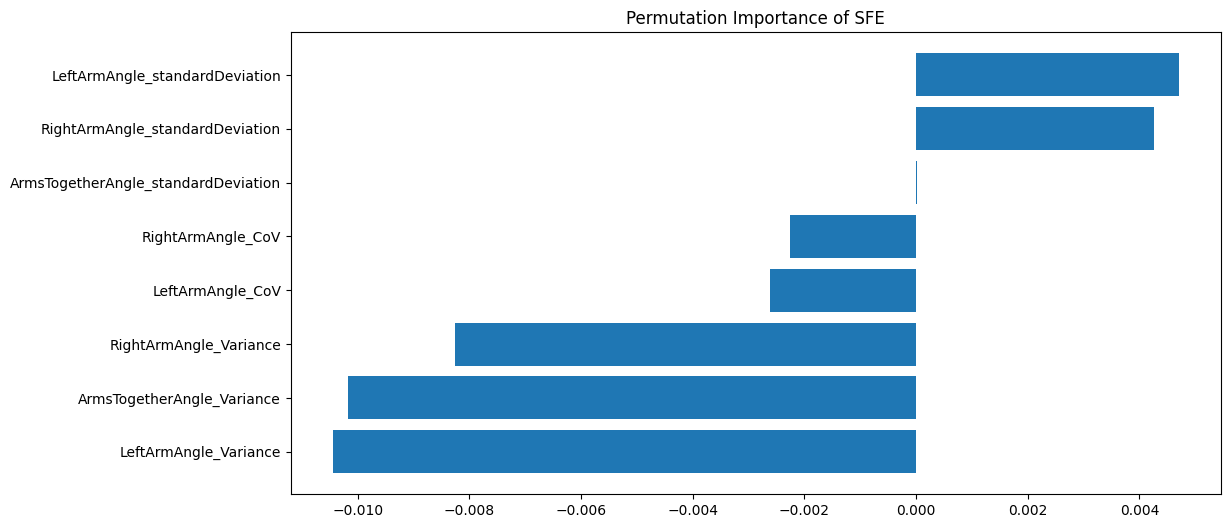

---------------- GESTO STL 🕺🏻-----------------


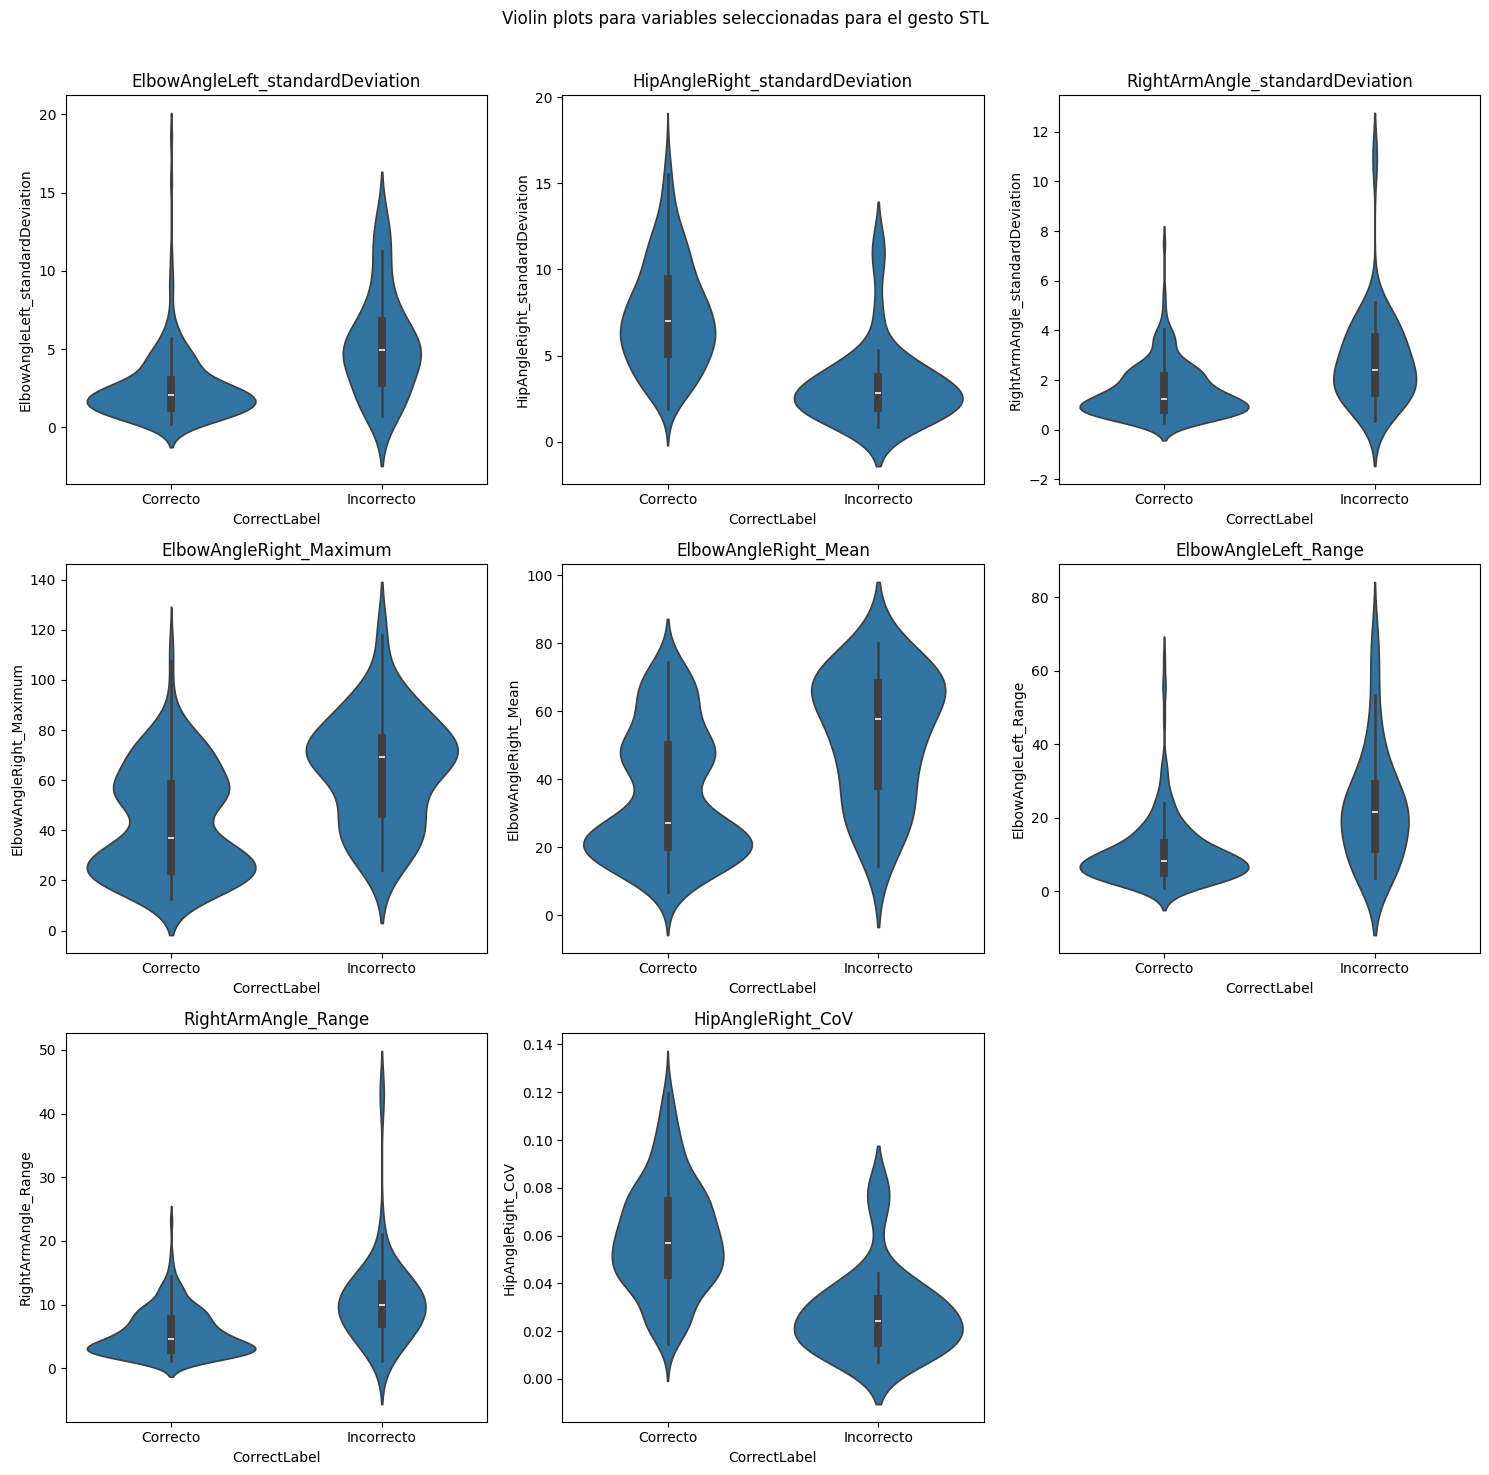

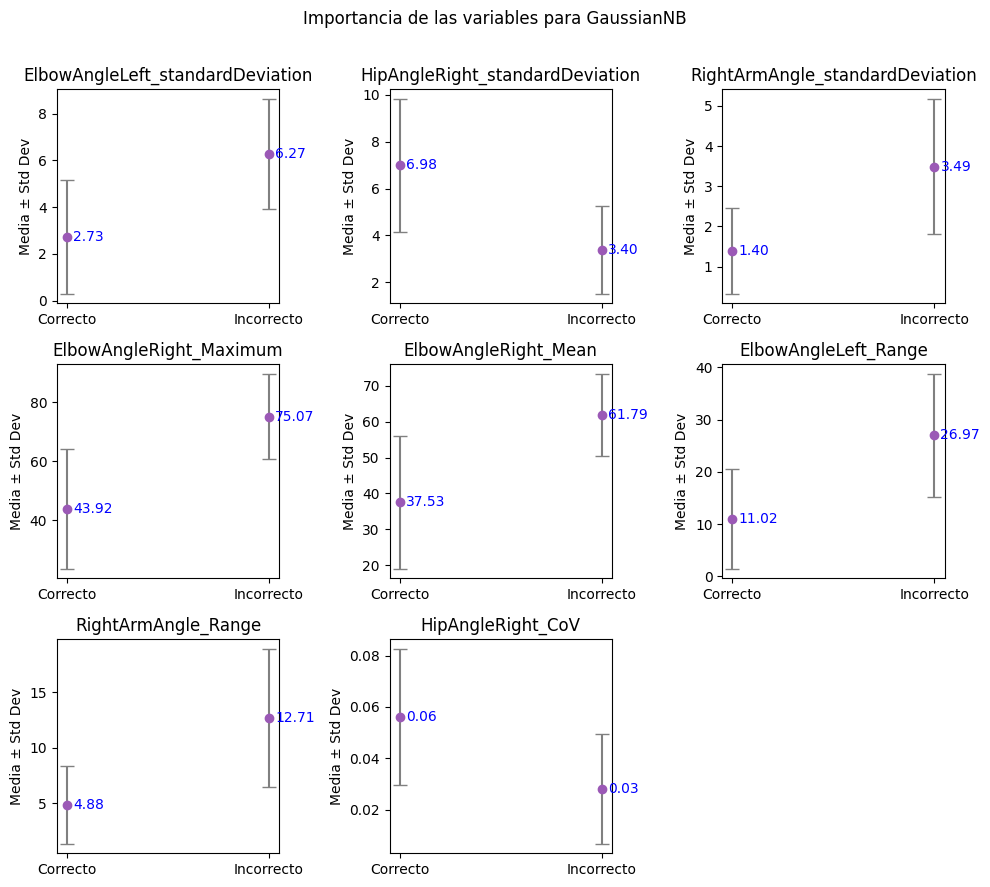

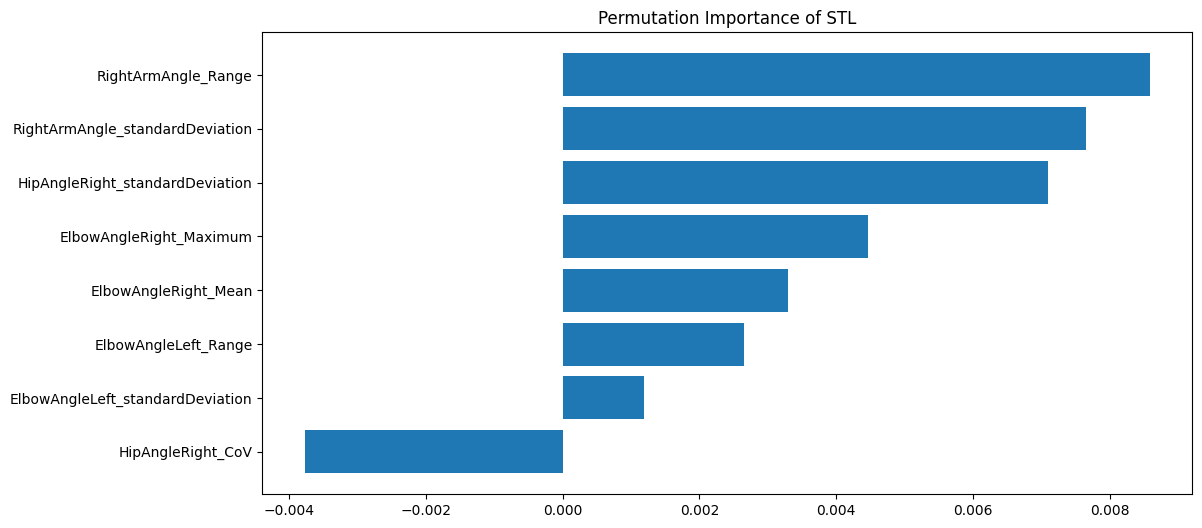

---------------- GESTO STR 🕺🏻-----------------


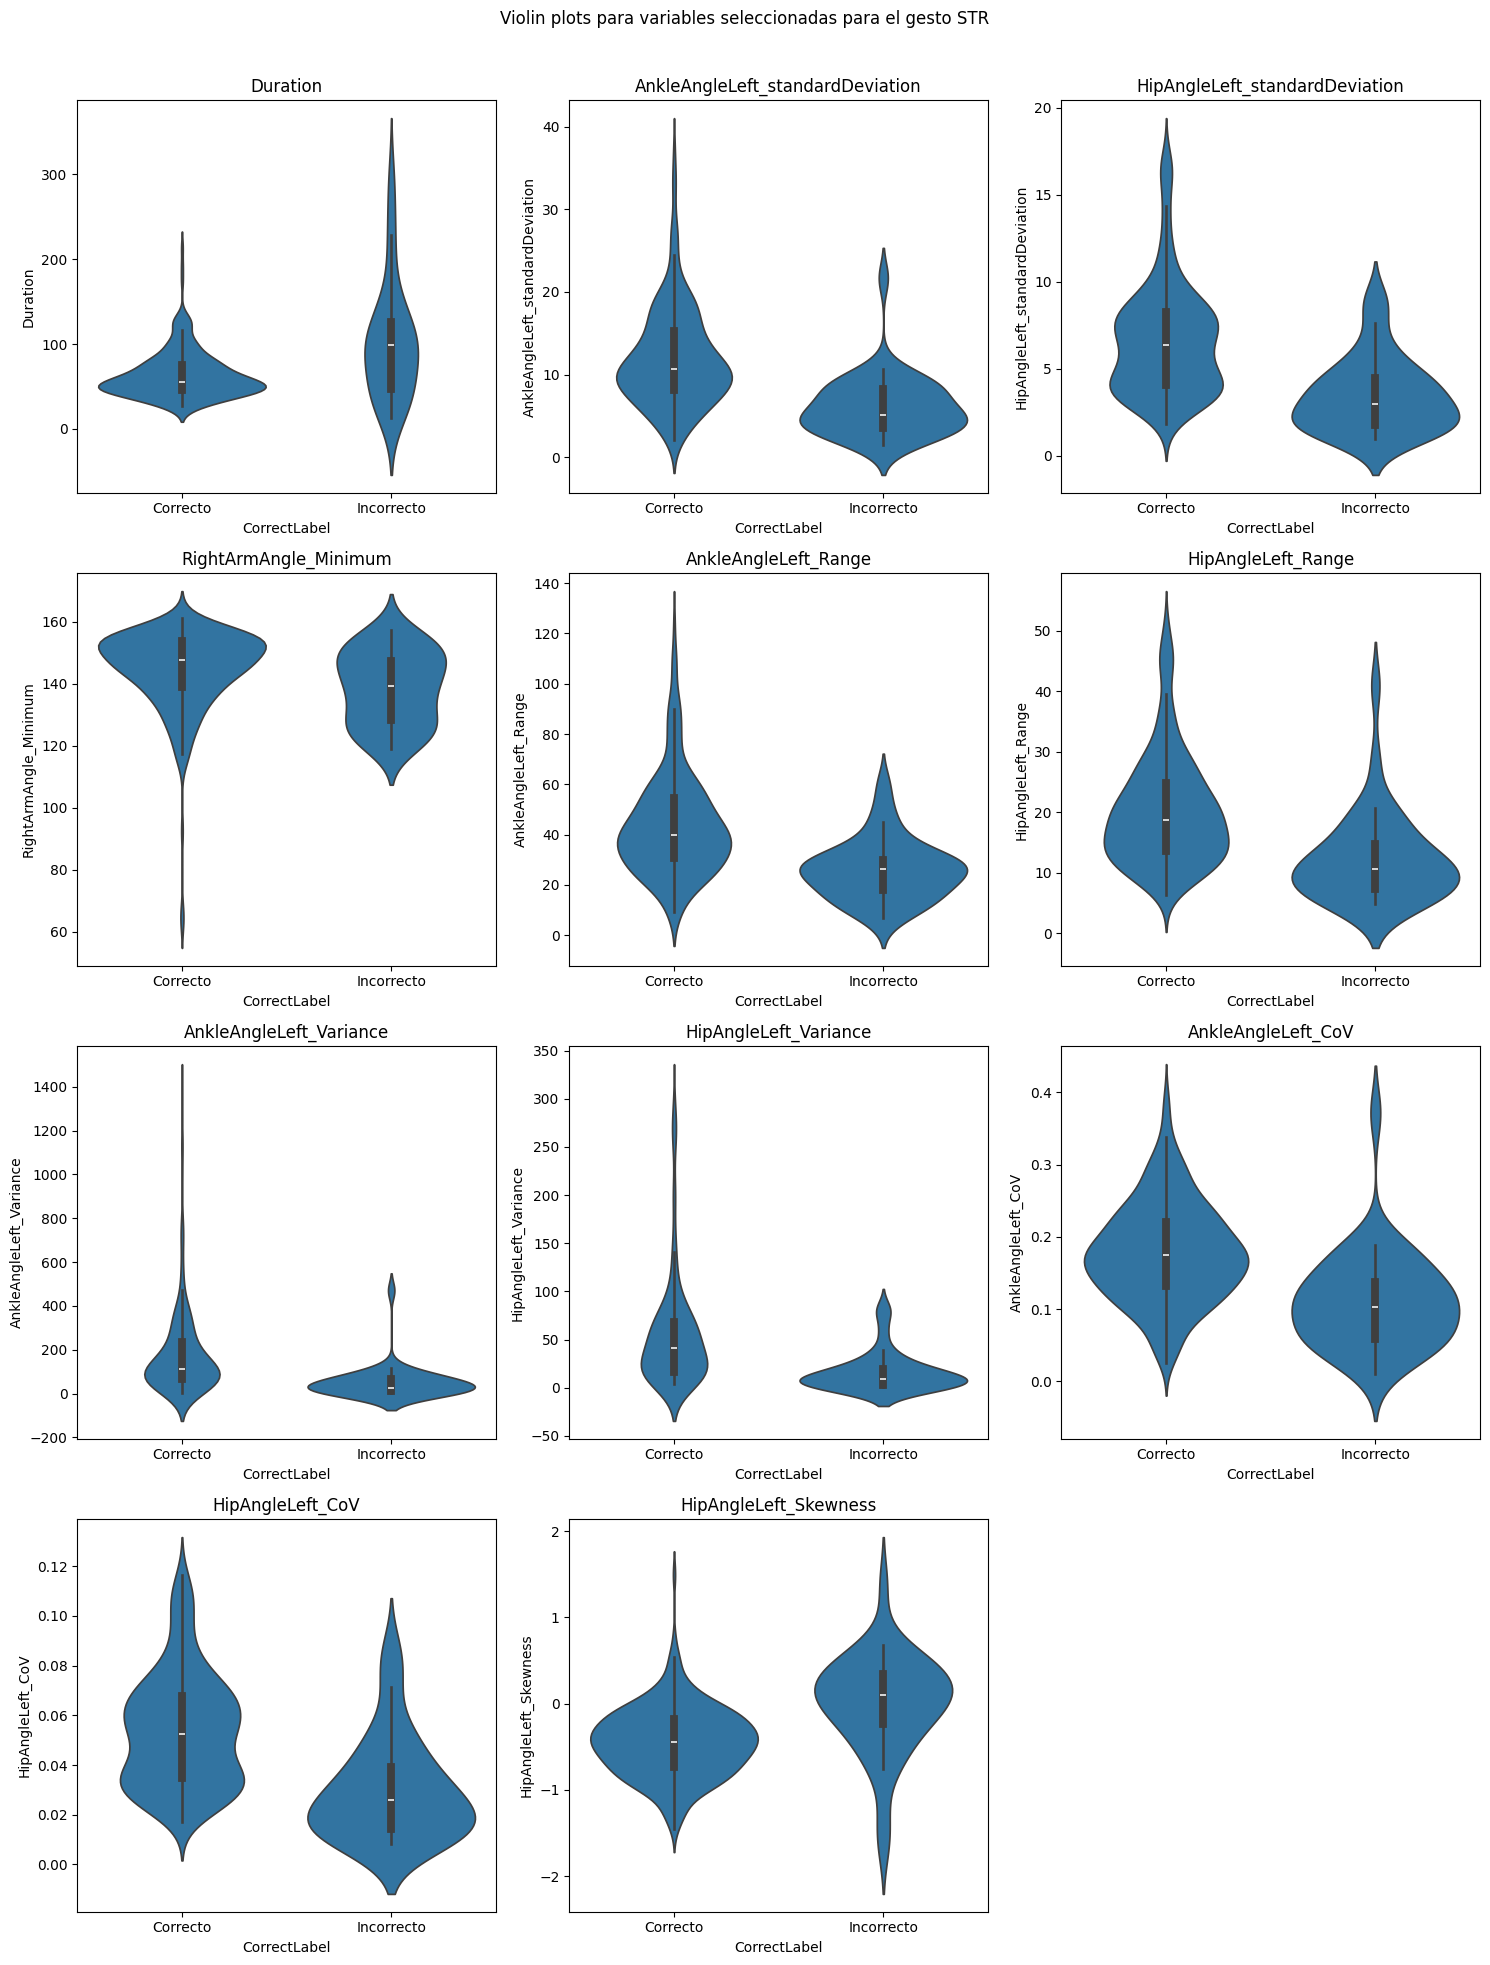

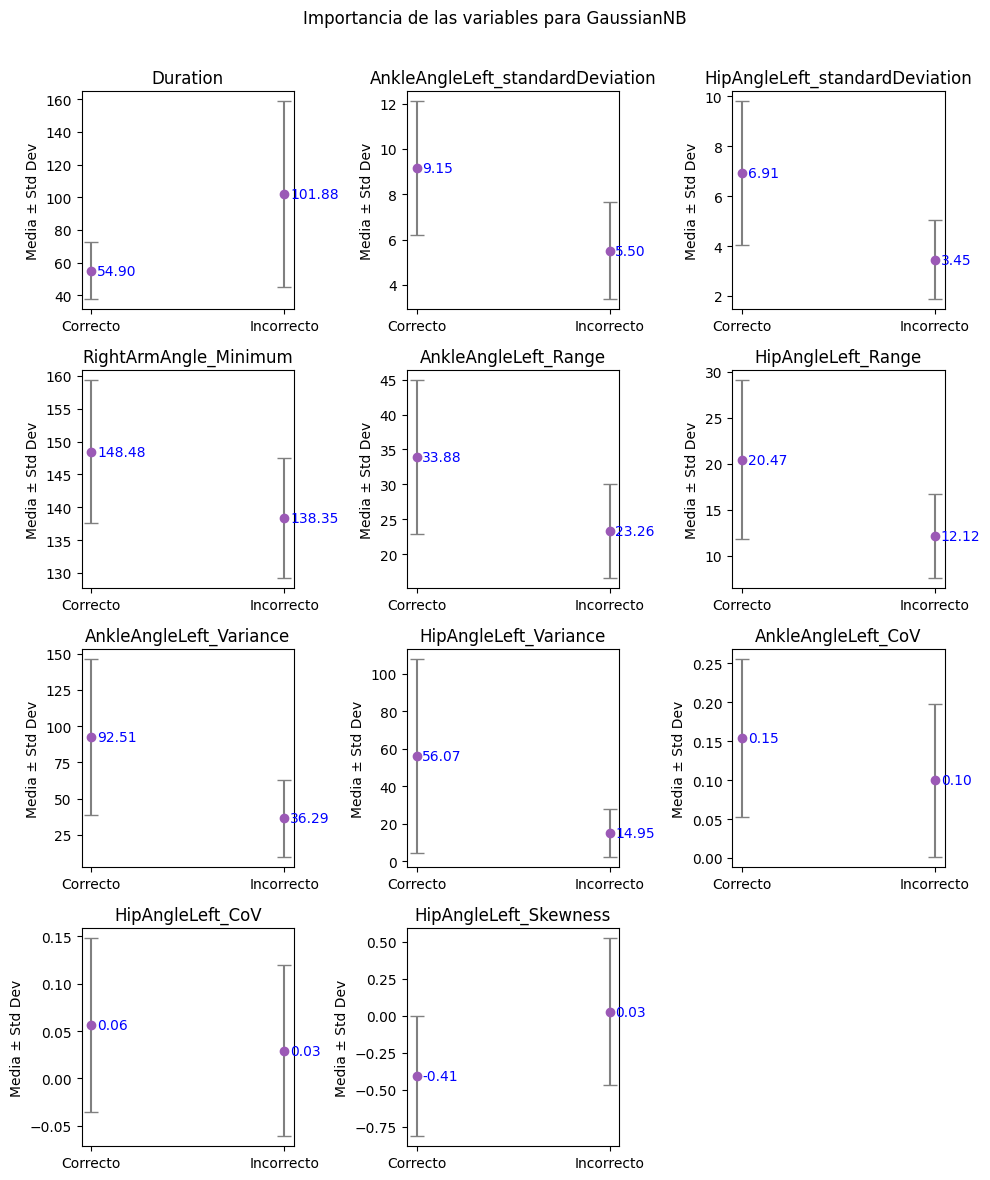

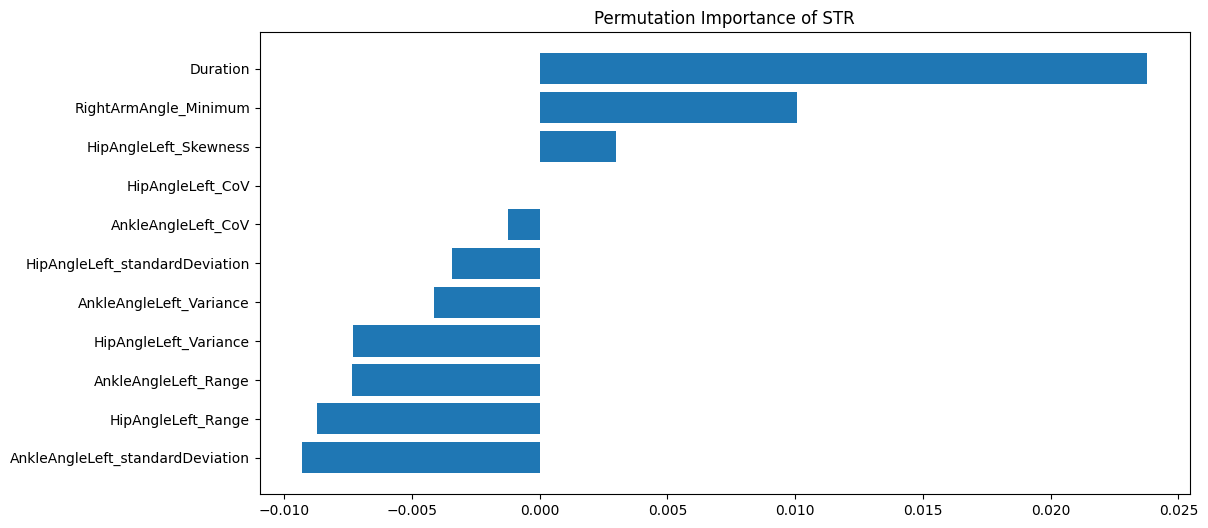

In [7]:
gestures = df['GestureName'].unique()

for gesture in gestures:
    print(f'---------------- GESTO {gesture} 🕺🏻-----------------')
    df_gesture = df[df['GestureName'] == gesture]
    y = df_gesture['CorrectLabel']
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    modelo_gesto_path = f'../Resultados/modelo_{gesture}.sav'
    best_pipeline, expected_columns = joblib.load(modelo_gesto_path)

    # Variables seleccionadas
    preprocessor = best_pipeline.named_steps['preprocessing']
    feature_names = preprocessor.get_feature_names_out()

    select_kbest = best_pipeline.named_steps['select_features']

    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    # Clean feature names
    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]

    # Create a DataFrame with the selected features
    df_selected = df_gesture[selected_features]

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'{feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Violin plots para variables seleccionadas para el gesto {gesture}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__

    if classifier_name == 'GaussianNB':
        # Extract means and variances
        means = classifier.theta_
        variances = classifier.var_

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
        axes = axes.flatten()
    
        for i, feature in enumerate(selected_features):
            axes[i].errorbar([0, 1], means[:, i], yerr=np.sqrt(variances[:, i]),
                             fmt='o', capsize=5, color='#9b59b6',
                             ecolor='gray')
            for j in range(2):  
                axes[i].text(j+0.03, means[j, i], f'{means[j, i]:.2f}', 
                     ha='left', va='center', fontsize=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Correcto', 'Incorrecto'])
            axes[i].set_ylabel('Media ± Std Dev')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        

    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
      
    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()
    
    elif classifier_name == 'SVC' and classifier.kernel == 'linear':
        weights = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, weights, color='blue')
        plt.axvline(x=0, color='grey', linestyle='--')
        plt.xlabel("Valor del peso (Importancia de la característica)")
        plt.title("Importancia de las características en el clasificador SVC")

    fig.suptitle(f'Importancia de las variables para {classifier_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Permutation Importance
    perm_importance = permutation_importance(classifier, df_selected, y, scoring='f1',n_repeats=10)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df_selected.columns)[sorted_idx])
    plt.title(f'Permutation Importance of {gesture}')
    plt.show()